# Descargar datos

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings

from datetime import datetime, timedelta, date
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.neighbors import KNeighborsRegressor
import scipy.stats


%matplotlib inline 
plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
data = pd.read_csv('ALUA.BA.csv')

In [3]:
data = data.drop(['Open','High','Low','Close','Volume'],axis = 1)
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True) 
data = data.set_index(['Date'])

In [4]:
data['Adj_close']= data['Adj Close']
data = data.drop(['Adj Close'],axis = 1)

In [5]:
train= data[:233]
test = data[233:]
print(len(train), len(test))

233 12


# Visualizar datos

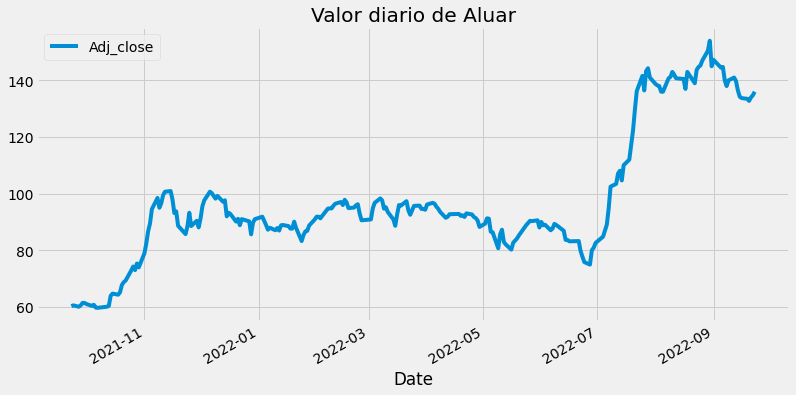

In [6]:
data.plot(figsize=(12,6), title= 'Valor diario de Aluar', fontsize=14)
plt.show()

In [7]:
data

,Adj_close
Date,
2021-09-23,60.245819
2021-09-24,60.535461
2021-09-27,60.052719
2021-09-28,60.535461
2021-09-29,61.404388
...,...
2022-09-19,133.500000
2022-09-20,132.750000
2022-09-21,134.000000


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj_close,245.0,97.832836,22.58794,59.666531,87.063118,91.856483,98.312843,154.0


vamos a trabajar solo con los datos de entrenamiento

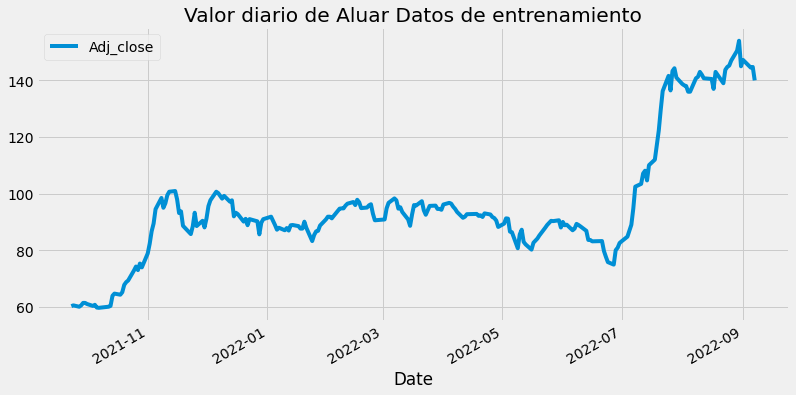

In [9]:
train.plot(figsize=(12,6), title= 'Valor diario de Aluar Datos de entrenamiento', fontsize=14)
plt.show()

In [10]:
print(train.describe())
print(test.describe())
print(data.describe())

        Adj_close
count  233.000000
mean    95.857489
std     21.359096
min     59.666531
25%     86.867470
50%     91.465187
75%     97.041138
max    154.000000
        Adj_close
count   12.000000
mean   136.187500
std      2.850688
min    132.750000
25%    133.937500
50%    135.375000
75%    138.437500
max    141.000000
        Adj_close
count  245.000000
mean    97.832836
std     22.587940
min     59.666531
25%     87.063118
50%     91.856483
75%     98.312843
max    154.000000


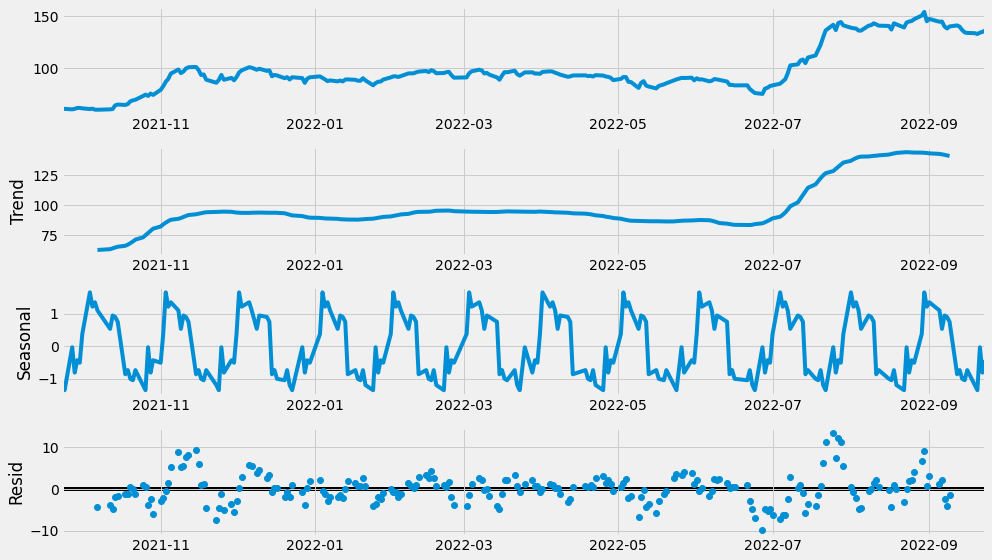

In [11]:
rcParams['figure.figsize'] = 14, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive',period=20 )
fig = decomposition.plot()
plt.show()

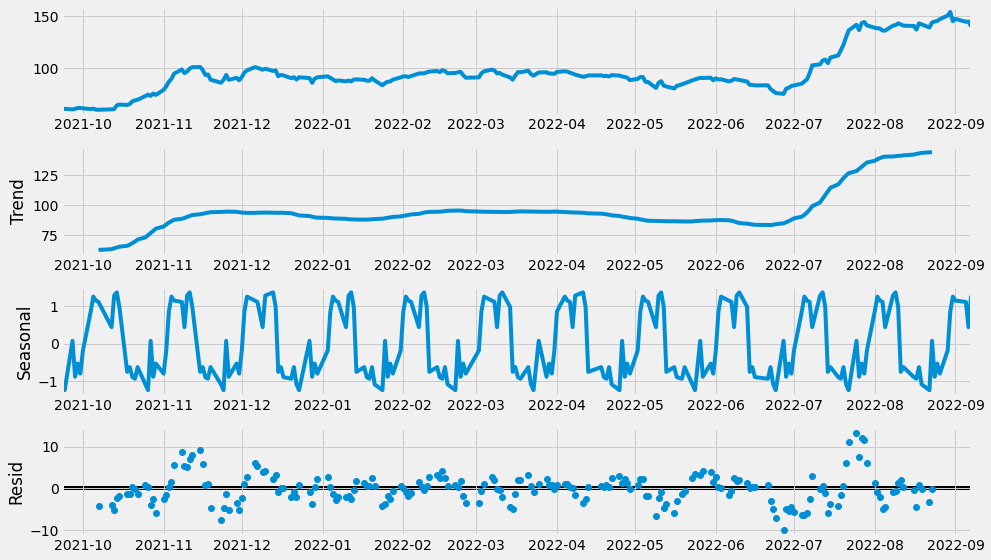

In [12]:
rcParams['figure.figsize'] = 14, 8
decomposition = sm.tsa.seasonal_decompose(train, model='additive',period=20 )
fig = decomposition.plot()
plt.show()

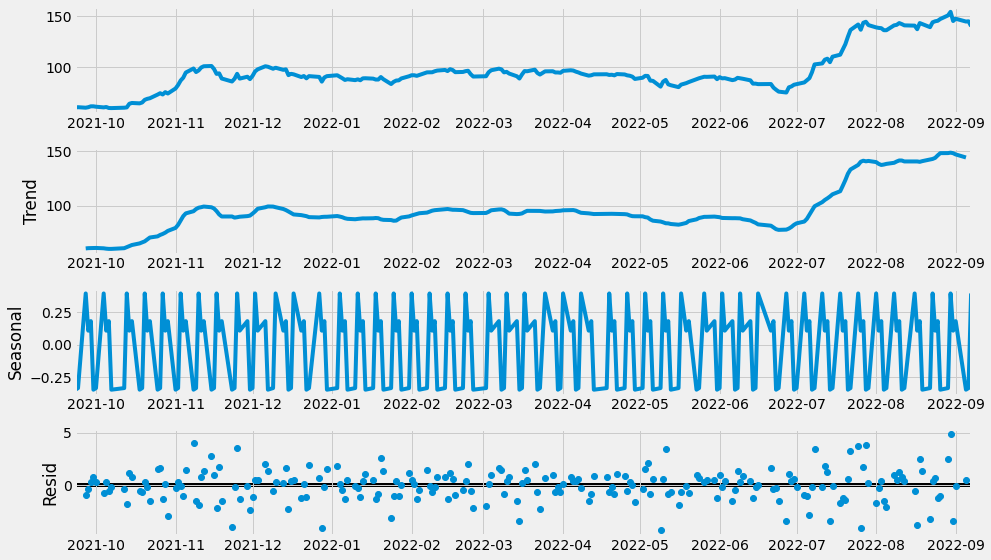

In [13]:
rcParams['figure.figsize'] = 14, 8
decomposition = sm.tsa.seasonal_decompose(train, model='additive',period=5 )
fig = decomposition.plot()
plt.show()

# Anlisis de estacionaridad

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=ventana_de_tiempo).mean()
    rolstd = pd.Series(timeseries).rolling(window=ventana_de_tiempo).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='lower left')
    plt.xticks(rotation=90)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

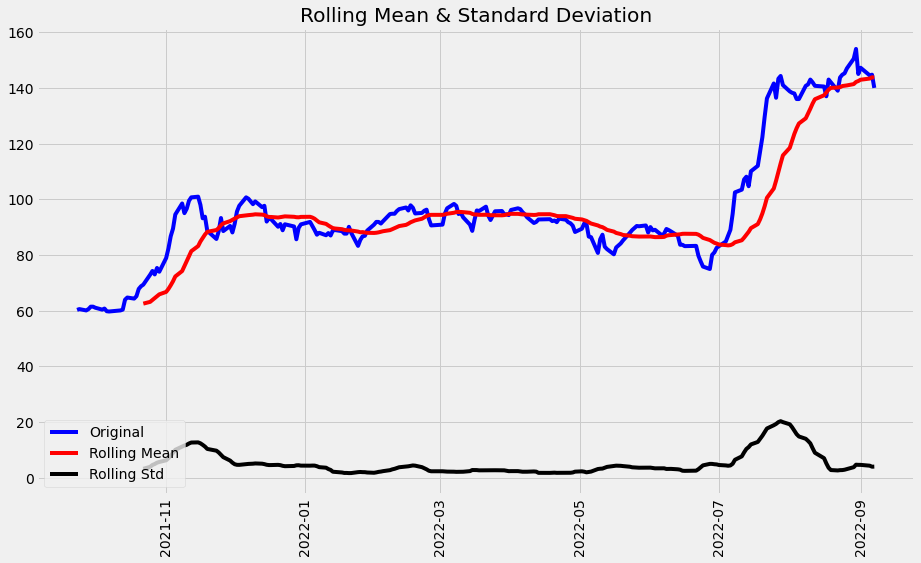

Results of Dickey-Fuller Test:
Test Statistic                  -1.119188
p-value                          0.707359
#Lags Used                       3.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


In [15]:
ventana_de_tiempo = 20
test_stationarity(train.Adj_close)

La serie no es estacionaria por que p-value > 0.05

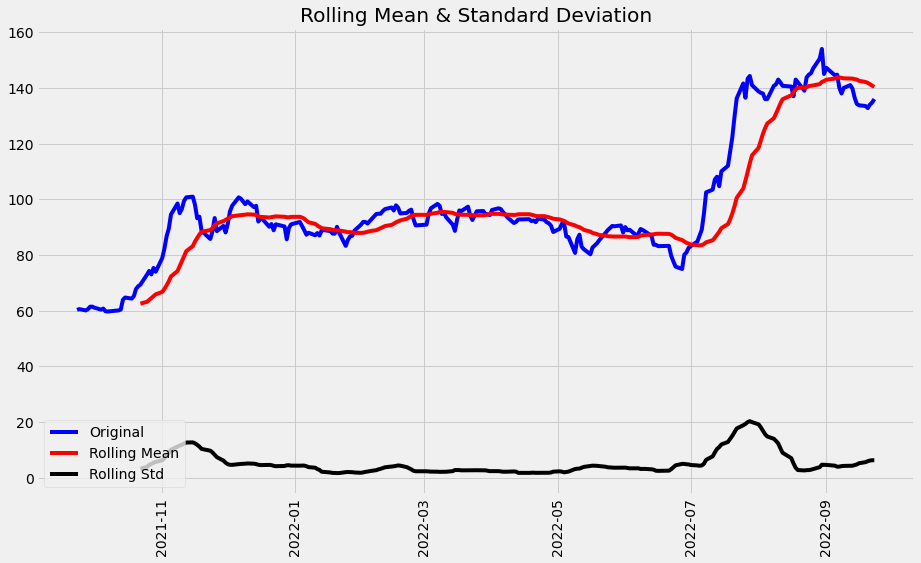

Results of Dickey-Fuller Test:
Test Statistic                  -1.205936
p-value                          0.671037
#Lags Used                       3.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


In [16]:
ventana_de_tiempo = 20
test_stationarity(data.Adj_close)

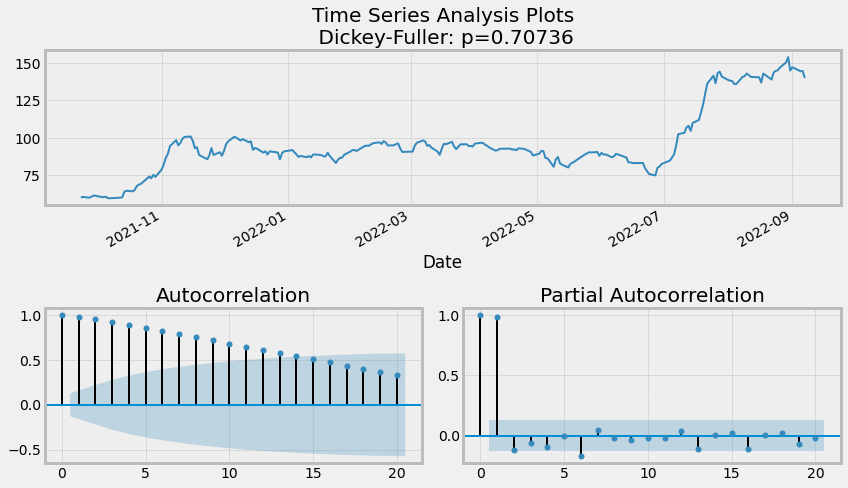

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(train.Adj_close)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax= acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(train, lags=20)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


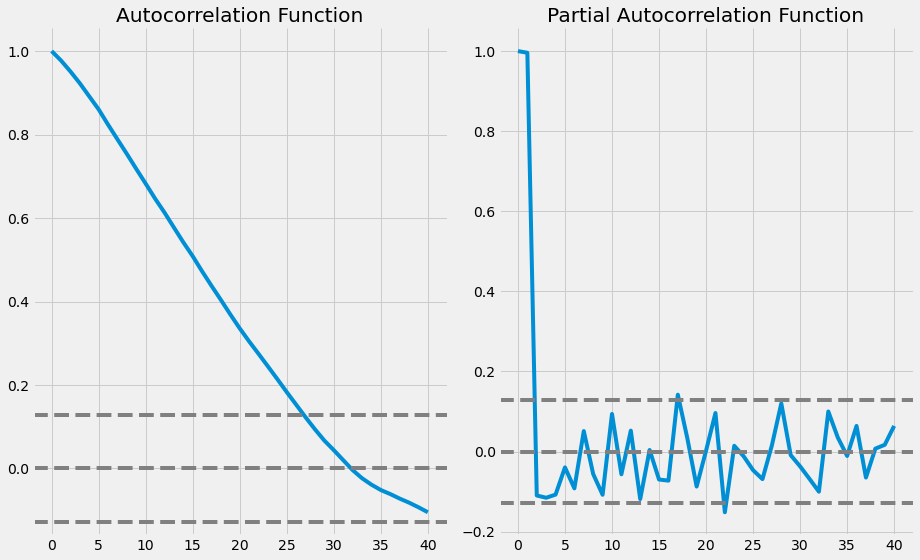

In [18]:
plt.figure(figsize=(13,8))

lag_acf = acf(train, nlags=40)
lag_pacf = pacf(train, nlags=40, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
x = np.array([0,5,10,15,20,25,30,35,40])
plt.xticks(x)


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
x = np.array([0,5,10,15,20,25,30,35,40])
plt.xticks(x)
plt.tight_layout()
sns.despine()

In [19]:
def check_stationarity(series):
    

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [20]:
check_stationarity(train)

ADF Statistic: -1.119188
p-value: 0.707359
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574
Non-stationary


In [21]:
first_diff = train.diff() #primera diferenciación
second_diff = train.diff().diff() #segunda diferenciación

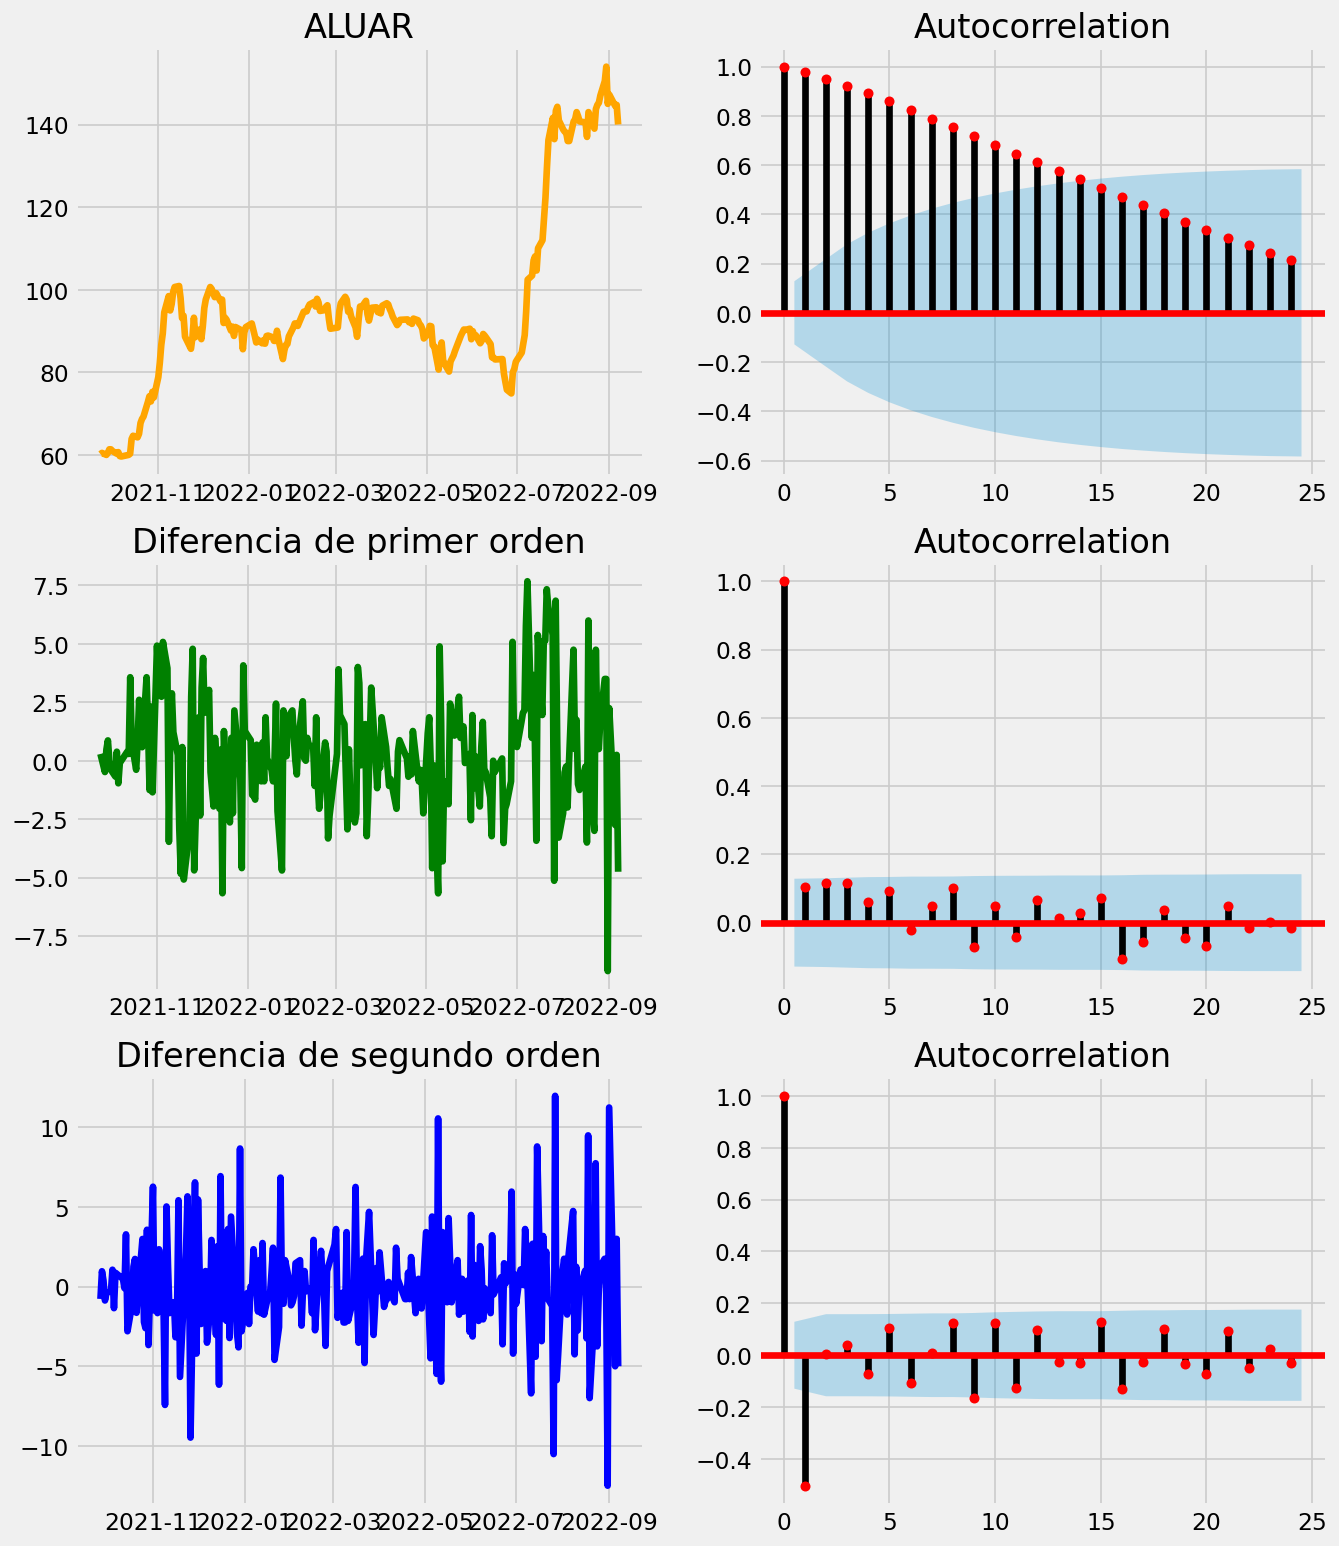

In [22]:
plt.rcParams.update({'figure.figsize':(12,15),'figure.dpi':120})
fig, axes = plt.subplots(3,2,sharex= False)
axes[0, 0].plot(train,color='orange'); axes[0, 0].set_title('ALUAR')
plot_acf(train,ax=axes[0,1],color = 'r')

#Primera diferencia
axes[1,0].plot(train.diff(),color='g'); axes[1,0].set_title('Diferencia de primer orden')
plot_acf(train.diff().dropna(),ax=axes[1,1],color = 'r')

#Segunda diferencia
axes[2,0].plot(train.diff().diff(),color='b'); axes[2,0].set_title('Diferencia de segundo orden')
plot_acf(train.diff().diff().dropna(),ax=axes[2,1],color = 'r')

plt.show()

Al analizar la funcion de autocorrelacion, podemos notar que nuestra serie de datos no es estacionaria, ya que las autocorrelacion decaen lentamente, por lo que habra que diferenciarlo para, que la serie si sea estacionaria.
Una vez diferenciada, podemos ver cuantos retardos seran los optimos.

In [ ]:
"""plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':80})

# Serie Original
fig, axes = plt.subplots(1, 3, sharex=True)
axes[0].plot(train) 
axes[0].set_title('Serie original')

# Primera Diferenciación
axes[1].plot(first_diff.dropna())
axes[1].set_title('1ra Diferenciación')

# Segunda Diferenciación
axes[2].plot(second_diff.dropna())
axes[2].set_title('2da Diferenciación')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)"""

"plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':80})\n\n# Serie Original\nfig, axes = plt.subplots(1, 3, sharex=True)\naxes[0].plot(train) \naxes[0].set_title('Serie original')\n\n# Primera Diferenciación\naxes[1].plot(first_diff.dropna())\naxes[1].set_title('1ra Diferenciación')\n\n# Segunda Diferenciación\naxes[2].plot(second_diff.dropna())\naxes[2].set_title('2da Diferenciación')\n\nfor ax in fig.axes:\n    plt.sca(ax)\n    plt.xticks(rotation=90)"

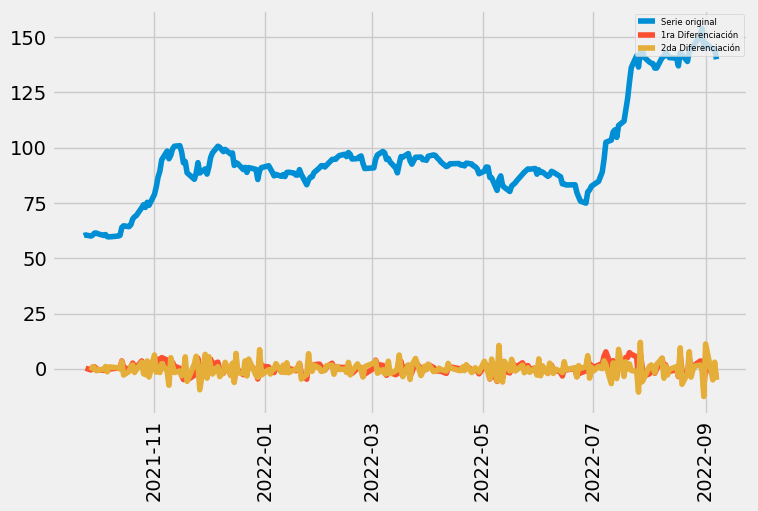

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(8,5), dpi=100, sharex=True)

axes.plot(train, label='Serie original')
axes.plot(first_diff, label='1ra Diferenciación')
axes.plot(second_diff, label='2da Diferenciación')
axes.legend(loc='upper right', fontsize=6)
plt.xticks(rotation=90)

plt.show()

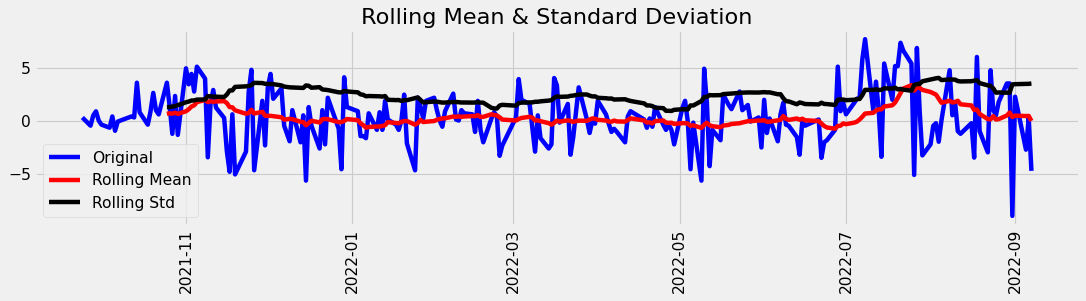

Results of Dickey-Fuller Test:
Test Statistic                -6.895795e+00
p-value                        1.319960e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


In [25]:
ventana_de_tiempo = 20
test_stationarity(first_diff.Adj_close.dropna())

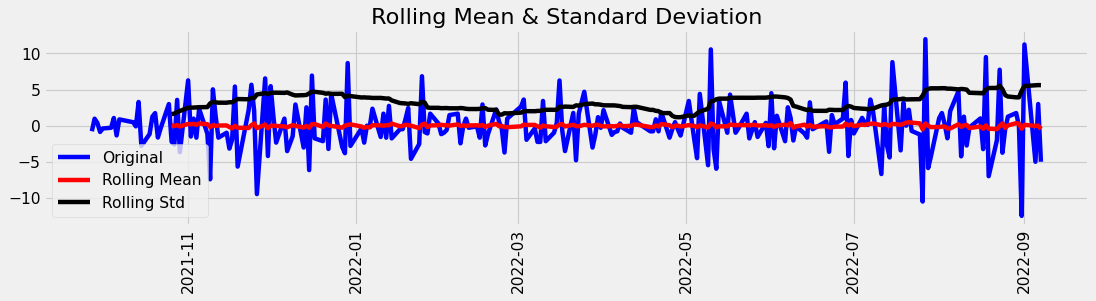

Results of Dickey-Fuller Test:
Test Statistic                -7.026295e+00
p-value                        6.351827e-10
#Lags Used                     1.000000e+01
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


In [26]:
test_stationarity(second_diff.Adj_close.dropna())

**Los resultados del test de estacionariedad aplicado a la serie diferenciada indican que una diferenciación sería suficiente para obtener datos estacionarios pero con dos diferenciaciones también alcanzamos el mismo resultado.**

# Encontrar P optimo

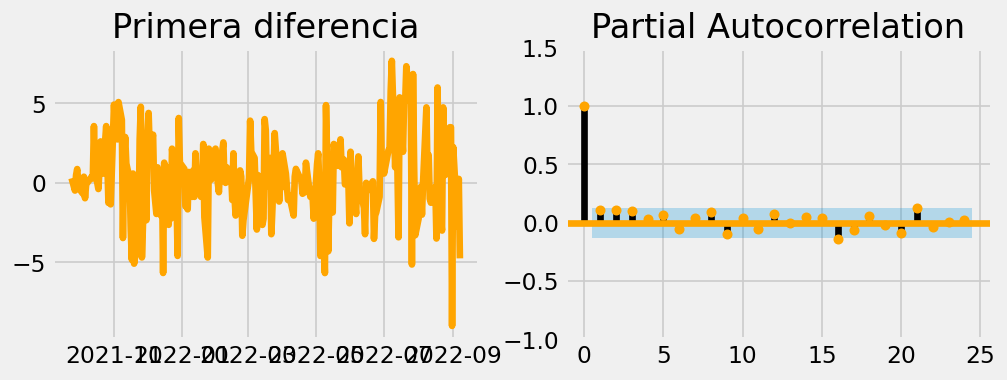

In [27]:
plt.rcParams.update({'figure.figsize':(9,3),'figure.dpi':120})
fig, axes = plt.subplots(1,2,sharex= False)
axes[1].set(ylim=(-1,1.5))
axes[0].plot(train.diff(),color='orange'); axes[0].set_title('Primera diferencia')
plot_pacf(train.diff().dropna(),ax=axes[1],color = 'orange')




plt.show()

**El valor de p debería ser 1 pues es el valor de retraso en el cual el gráfico de Autocorrelación Parcial (PACF) entra la región de confianza**

# Elegir MA optimo

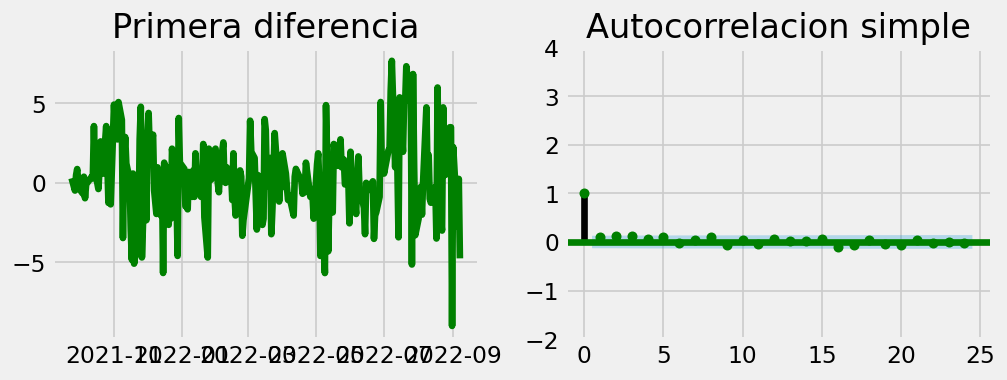

In [28]:
fig, axes = plt.subplots(1,2,sharex= False)
axes[1].set(ylim=(-2,4))
axes[0].plot(train.diff(),color='green'); axes[0].set_title('Primera diferencia')
plot_acf(train.diff().dropna(),ax=axes[1],color = 'green')
plt.title('Autocorrelacion simple')



plt.show()

**El valor de q debería ser también 1 pues es el valor de retraso en el cual el gráfico de Autocorrelación (ACF) entra la región de confianza**

# ARIMA

**Dado los analisis realizados anteriormente podemos concluir que un buen modelo es ARIMA(1,1,1)**

In [29]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(np.log(train), order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 519.904
Date:                Sat, 22 Oct 2022   AIC                          -1033.809
Time:                        18:37:41   BIC                          -1023.469
Sample:                             0   HQIC                         -1029.639
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8592      0.094      9.094      0.000       0.674       1.044
ma.L1         -0.7455      0.127     -5.892      0.000      -0.993      -0.498
sigma2         0.0007    5.8e-05     11.403      0.0

Ljung-box es la prueba de ruido blanco

In [30]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(model_fit.resid, lags=[1],return_df= True)

,lb_stat,lb_pvalue
1,0.000071,0.993295


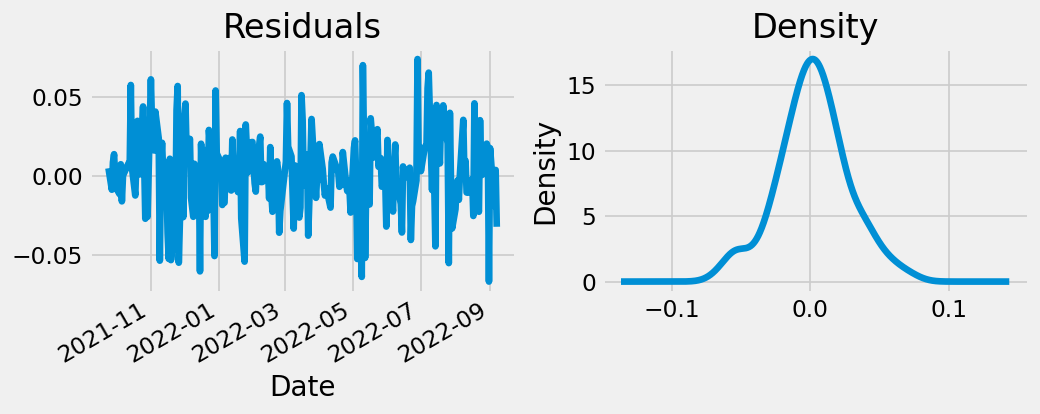

In [31]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

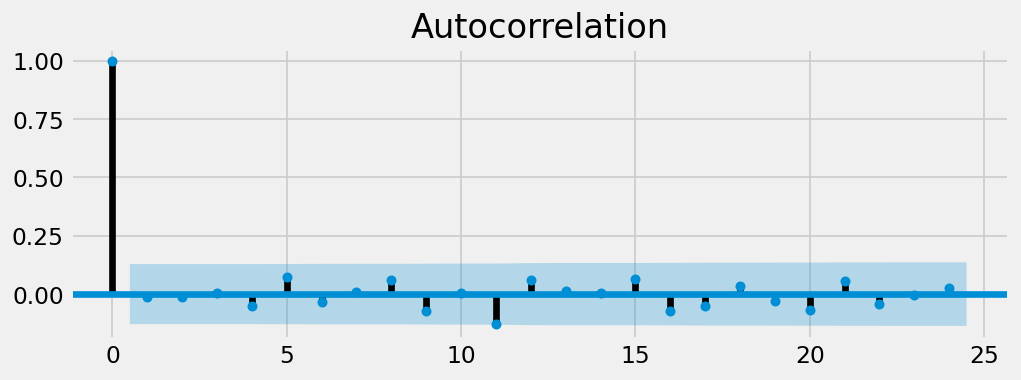

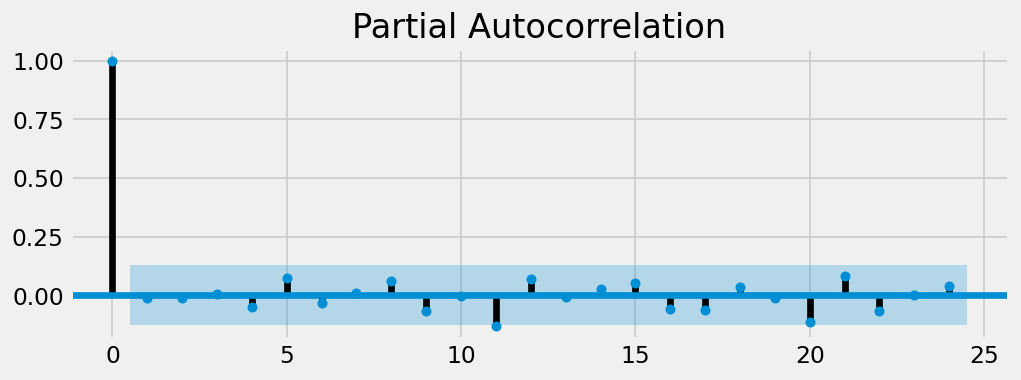

In [32]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

## Arima predicciones

In [33]:
pred_uc = model_fit.get_forecast(len(test))
pred_ci = pred_uc.conf_int()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [34]:
df = pd.read_csv('ALUA.BA.csv')

In [35]:
pred_ci['Date'] = df['Date'][233:]
pred_ci

,lower Adj_close,upper Adj_close,Date
233,4.886464,4.987313,2022-09-08
234,4.857331,5.008277,2022-09-09
235,4.832202,5.026387,2022-09-12
236,4.809265,5.043295,2022-09-13
237,4.787873,5.059506,2022-09-14
238,4.767710,5.075217,2022-09-15
239,4.748589,5.090514,2022-09-16
240,4.730382,5.105435,2022-09-19
241,4.712995,5.120000,2022-09-20
242,4.696350,5.134219,2022-09-21


In [36]:
pred_ci['Date'] = pd.to_datetime(pred_ci['Date'],infer_datetime_format=True) 
pred_ci = pred_ci.set_index(['Date'])
pred_ci

,lower Adj_close,upper Adj_close
Date,,
2022-09-08,4.886464,4.987313
2022-09-09,4.857331,5.008277
2022-09-12,4.832202,5.026387
2022-09-13,4.809265,5.043295
2022-09-14,4.787873,5.059506
2022-09-15,4.767710,5.075217
2022-09-16,4.748589,5.090514
2022-09-19,4.730382,5.105435
2022-09-20,4.712995,5.120000


In [37]:
pred_ci['lower Adj_close'] = np.exp(pred_ci['lower Adj_close'])
pred_ci['upper Adj_close'] = np.exp(pred_ci['upper Adj_close'])
pred_ci

,lower Adj_close,upper Adj_close
Date,,
2022-09-08,132.484289,146.542127
2022-09-09,128.680348,149.646634
2022-09-12,125.487029,152.381508
2022-09-13,122.641419,154.979809
2022-09-14,120.045748,157.512671
2022-09-15,117.649549,160.006958
2022-09-16,115.421338,162.473348
2022-09-19,113.338897,164.915795
2022-09-20,111.385221,167.335323


In [38]:
pred_uc.predicted_mean = np.exp(pred_uc.predicted_mean)
pred_uc.predicted_mean

233    139.336031
234    138.768083
235    138.281968
236    137.865673
237    137.509005
238    137.203303
239    136.941196
240    136.716401
241    136.523558
242    136.358091
243    136.216086
244    136.094198
Name: predicted_mean, dtype: float64

In [39]:
pred_ci['predict'] =list((pred_uc.predicted_mean))
pred_ci

,lower Adj_close,upper Adj_close,predict
Date,,,
2022-09-08,132.484289,146.542127,139.336031
2022-09-09,128.680348,149.646634,138.768083
2022-09-12,125.487029,152.381508,138.281968
2022-09-13,122.641419,154.979809,137.865673
2022-09-14,120.045748,157.512671,137.509005
2022-09-15,117.649549,160.006958,137.203303
2022-09-16,115.421338,162.473348,136.941196
2022-09-19,113.338897,164.915795,136.716401
2022-09-20,111.385221,167.335323,136.523558


In [40]:
pred_uc.predicted_mean['date'] = df['Date'][233:]
#pred_uc.predicted_mean['date'] = pd.to_datetime(pred_uc.predicted_mean['date'],infer_datetime_format=True) 
#pred_uc.predicted_mean = pred_uc.predicted_mean.set_index(['date'])
pred_uc.predicted_mean

233                                            139.336031
234                                            138.768083
235                                            138.281968
236                                            137.865673
237                                            137.509005
238                                            137.203303
239                                            136.941196
240                                            136.716401
241                                            136.523558
242                                            136.358091
243                                            136.216086
244                                            136.094198
date    233    2022-09-08
234    2022-09-09
235    202...
Name: predicted_mean, dtype: object

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


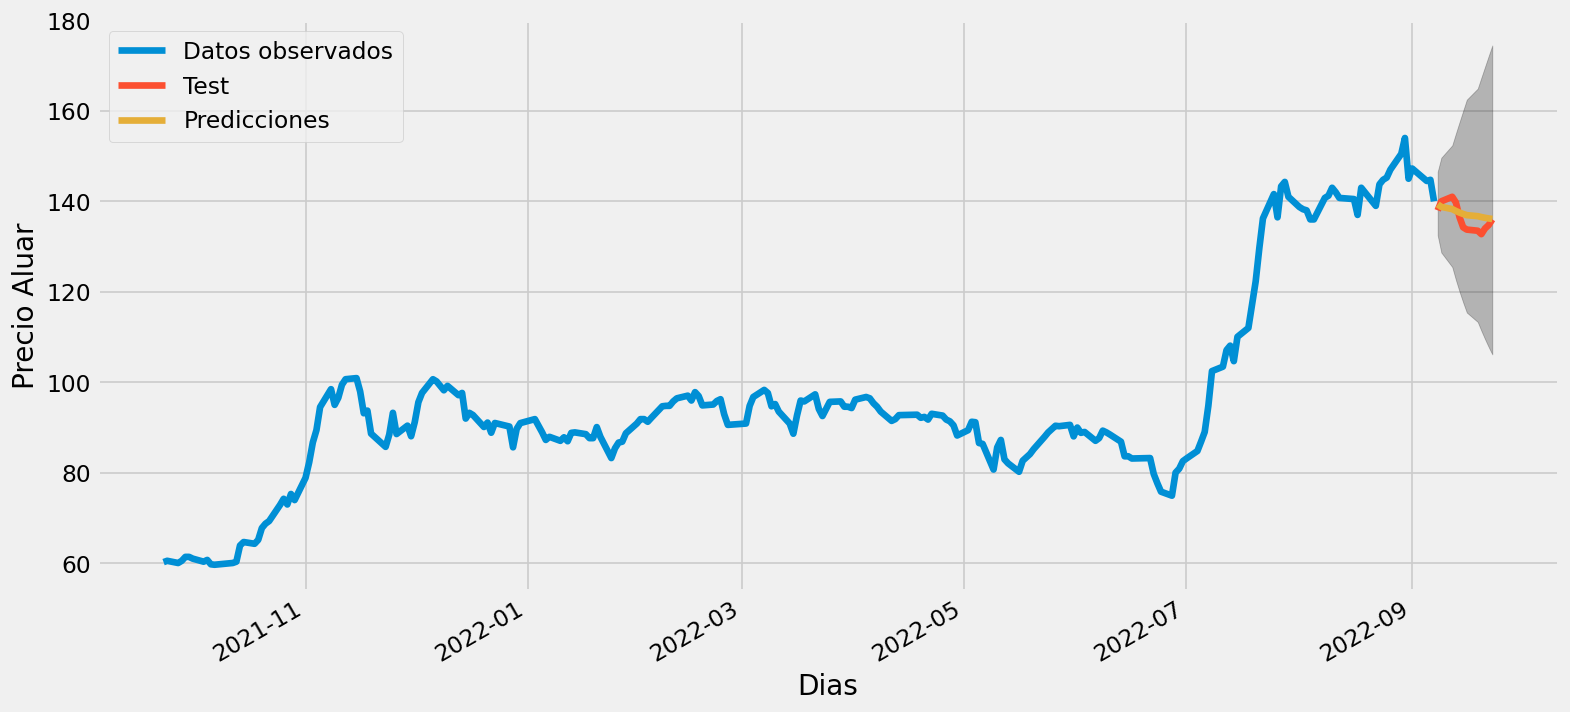

In [41]:
pred_uc = model_fit.get_forecast(steps=12)
#pred_ci = pred_uc.conf_int()
ax = train.Adj_close.plot(label='Datos observados', figsize=(14, 7))
ax = test.Adj_close.plot(label='Test', figsize=(14, 7))

#pred_uc.predicted_mean.plot(ax=ax, label='Predicciones')
pred_ci.predict.plot(ax=ax, label='Predicciones')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Dias')
ax.set_ylabel('Precio Aluar')
plt.legend()
plt.show()

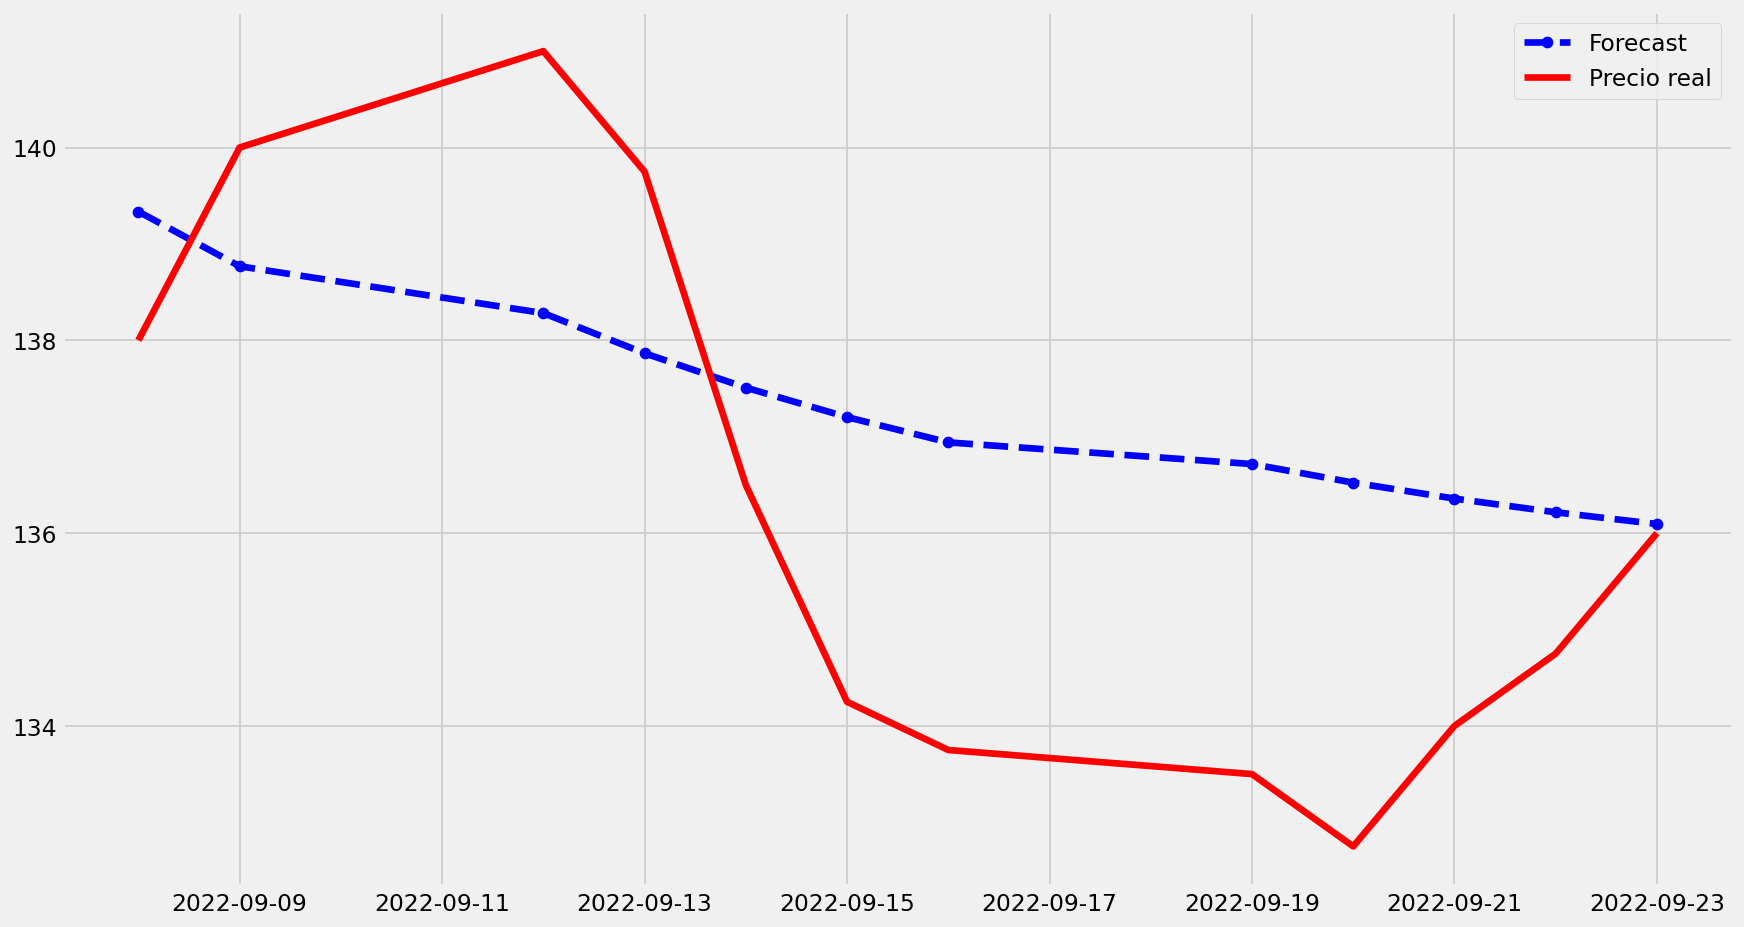

In [42]:
plt.figure(figsize=(16,9))
plt.grid(True)
date_range = df[233:].index
plt.plot(pred_ci['predict'], color = 'blue',marker = 'o',linestyle = 'dashed', label = 'Forecast')
plt.plot(test, color = 'red', label = 'Precio real')
plt.legend()

In [43]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(model_fit.resid, lags=[1],return_df= True)

,lb_stat,lb_pvalue
1,0.000071,0.993295


Como vemos el modelo ARIMA supo entender la tendencia de la serie temporal, y en una prediccion de 12 dias, predicio a la perfeccion el ultimo dia.

### Metricas

In [44]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

In [45]:
predict = pred_ci['predict']
predict

Date
2022-09-08    139.336031
2022-09-09    138.768083
2022-09-12    138.281968
2022-09-13    137.865673
2022-09-14    137.509005
2022-09-15    137.203303
2022-09-16    136.941196
2022-09-19    136.716401
2022-09-20    136.523558
2022-09-21    136.358091
2022-09-22    136.216086
2022-09-23    136.094198
Name: predict, dtype: float64

In [46]:
mean_squared_error(test, predict)

5.539054525967892

In [47]:
pred = np.exp(model_fit.predict())
pred

Date
2021-09-23      1.000000
2021-09-24     60.245819
2021-09-27     60.578657
2021-09-28     60.020067
2021-09-29     60.571405
                 ...    
2022-08-31    154.987742
2022-09-01    144.698920
2022-09-05    147.279551
2022-09-06    144.212257
2022-09-07    144.563463
Name: predicted_mean, Length: 233, dtype: float64

In [48]:
mean_squared_error(train, pred)

21.495927846791123

El error medio del conjunto de entrenamiento es 21, mientras que el error del conjunto de test es 5.5

# Punto 2:
### evaluar los distintos modelos y comparlos con la version de excel

##AR(P)

### AR 1

In [ ]:
ar1 = ARIMA(train, order=(1,0,0))
ar1fit = ar1.fit()
print(ar1fit.summary())

                              ARMA Model Results                              
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                     ARMA(1, 0)   Log Likelihood                -555.975
Method:                       css-mle   S.D. of innovations              2.602
Date:                Fri, 21 Oct 2022   AIC                           1117.949
Time:                        12:16:29   BIC                           1128.303
Sample:                             0   HQIC                          1122.124
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              99.0110     28.889      3.427      0.001      42.389     155.633
ar.L1.Adj_close     0.9970      0.004    264.287      0.000       0.990       1.004
                                

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

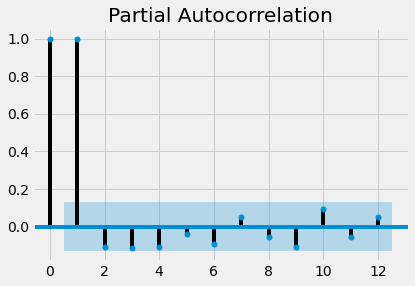

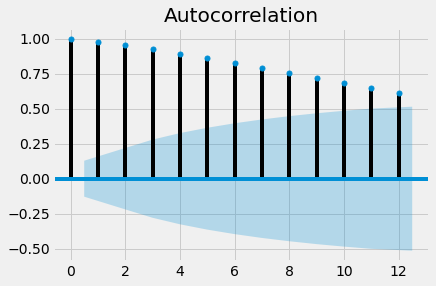

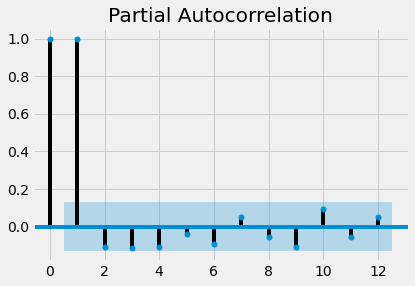

In [ ]:
plot_acf(train,lags=12)
plot_pacf(train,lags=12, method='ols')

In [ ]:
pred_ar1 = ar1fit.predict()
pred_ar1

Date
2021-09-23     99.014606
2021-09-24     60.362612
2021-09-27     60.651382
2021-09-28     60.170094
2021-09-29     60.651382
                 ...    
2022-08-31    153.834353
2022-09-01    144.861466
2022-09-05    147.104688
2022-09-06    144.362973
2022-09-07    144.612219
Name: predicted_mean, Length: 233, dtype: float64

In [ ]:
forecast_ar1 = ar1fit.forecast(len(test))
forecast_ar1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


233    139.876529
234    139.753430
235    139.630702
236    139.508344
237    139.386354
238    139.264732
239    139.143476
240    139.022585
241    138.902059
242    138.781896
243    138.662095
244    138.542654
Name: predicted_mean, dtype: float64

In [ ]:
mean_squared_error(train,pred_ar1)

13.181858524046696

In [ ]:
pred_ar1_test = ar1fit.get_forecast(len(test))
pred_ar1_test.predicted_mean = (pred_ar1_test.predicted_mean)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
mean_squared_error(test,pred_ar1_test.predicted_mean)

15.088881293322814

#### AR 1 log

In [ ]:
log_ar1 = ARIMA(np.log(train), order=(1,0,0))
log_ar1fit = log_ar1.fit()
print(log_ar1fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 513.001
Date:                Tue, 18 Oct 2022   AIC                          -1020.002
Time:                        00:53:57   BIC                          -1009.649
Sample:                             0   HQIC                         -1015.828
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5401      0.127     35.788      0.000       4.291       4.789
ar.L1          0.9904      0.007    146.582      0.000       0.977       1.004
sigma2         0.0007   6.34e-05     11.100      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
pred_ar1_log = np.exp(log_ar1fit.predict())
pred_ar1_log

Date
2021-09-23     93.700944
2021-09-24     60.502551
2021-09-27     60.790620
2021-09-28     60.310492
2021-09-29     60.790620
                 ...    
2022-08-31    153.265100
2022-09-01    144.391739
2022-09-05    146.610564
2022-09-06    143.898622
2022-09-07    144.145182
Name: predicted_mean, Length: 233, dtype: float64

In [ ]:
log_forecast_ar1 = np.exp(log_ar1fit.forecast(len(test)))
log_forecast_ar1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


233    139.459822
234    138.926899
235    138.401114
236    137.882352
237    137.370501
238    136.865451
239    136.367094
240    135.875323
241    135.390035
242    134.911128
243    134.438501
244    133.972056
Name: predicted_mean, dtype: float64

In [ ]:
mean_squared_error(train,pred_ar1_log)

11.592248219054653

In [ ]:
pred_ar1_log_test = ar1fit.get_forecast(len(test))
pred_ar1_log_test.predicted_mean = (pred_ar1_log_test.predicted_mean)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
mean_squared_error(test,pred_ar1_log_test.predicted_mean)

15.088881293322814

### AR2

In [ ]:
ar2 = ARIMA(train, order=(2,0,0))
ar2fit = ar2.fit()
print(ar2fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -554.186
Date:                Tue, 18 Oct 2022   AIC                           1116.373
Time:                        00:53:57   BIC                           1130.177
Sample:                             0   HQIC                          1121.939
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.4504     23.303      4.225      0.000      52.777     144.124
ar.L1          1.1210      0.050     22.364      0.000       1.023       1.219
ar.L2         -0.1248      0.051     -2.449      0.0

In [ ]:
pred_ar2 = ar2fit.predict()
pred_ar2

Date
2021-09-23     98.450361
2021-09-24     60.374212
2021-09-27     60.714937
2021-09-28     60.137613
2021-09-29     60.739039
                 ...    
2022-08-31    154.226875
2022-09-01    143.700681
2022-09-05    147.346370
2022-09-06    143.982679
2022-09-07    144.606186
Name: predicted_mean, Length: 233, dtype: float64

In [ ]:
forecast_ar2 = ar2fit.forecast(len(test))
forecast_ar2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


233    139.250055
234    139.002221
235    138.817996
236    138.642406
237    138.468559
238    138.295585
239    138.123375
240    137.951911
241    137.781189
242    137.611204
243    137.441954
244    137.273435
Name: predicted_mean, dtype: float64

In [ ]:
mean_squared_error(train,pred_ar2)

12.891980693202683

In [ ]:
pred_ar2 = ar2fit.get_forecast(len(test))
pred_ar2.predicted_mean = (pred_ar2.predicted_mean)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
mean_squared_error(test,pred_ar2.predicted_mean)

9.57965958568129

### AR 3

In [ ]:
ar3 = ARIMA(train, order=(3,0,0))
ar3fit = ar3.fit()
print(ar3fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -552.363
Date:                Tue, 18 Oct 2022   AIC                           1114.725
Time:                        00:53:58   BIC                           1131.981
Sample:                             0   HQIC                          1121.683
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.9636     20.868      4.599      0.000      55.064     136.864
ar.L1          1.1060      0.055     20.271      0.000       0.999       1.213
ar.L2          0.0153      0.093      0.166      0.8

In [ ]:
pred_ar3 = ar3fit.predict()
pred_ar3

Date
2021-09-23     95.963621
2021-09-24     60.381792
2021-09-27     60.723898
2021-09-28     60.209149
2021-09-29     60.699102
                 ...    
2022-08-31    154.549165
2022-09-01    144.207530
2022-09-05    146.116298
2022-09-06    144.244793
2022-09-07    144.195228
Name: predicted_mean, Length: 233, dtype: float64

In [ ]:
pred_ar3_test = ar3fit.get_forecast(len(test))
pred_ar3_test.predicted_mean = (pred_ar3_test.predicted_mean)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
mean_squared_error(train,pred_ar3)

12.002695939688321

In [ ]:
mean_squared_error(test,pred_ar3_test.predicted_mean)

5.2664468357630385

## MA(q)

In [ ]:
ma1 = ARIMA(train, order=(0,0,1))
ma1fit = ma1.fit()
print(ma1fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -901.400
Date:                Tue, 18 Oct 2022   AIC                           1808.800
Time:                        00:53:58   BIC                           1819.153
Sample:                             0   HQIC                          1812.975
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.8451      1.753     54.664      0.000      92.409      99.282
ma.L1          0.9242      0.024     38.951      0.000       0.878       0.971
sigma2       133.1133     12.341     10.787      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertib

In [ ]:
pred_ma = ma1fit.predict()
pred_ma

Date
2021-09-23     95.845055
2021-09-24     78.100519
2021-09-27     84.195251
2021-09-28     77.868098
2021-09-29     82.106338
                 ...    
2022-08-31    123.188120
2022-09-01    116.004679
2022-09-05    124.723534
2022-09-06    114.123448
2022-09-07    124.151637
Name: predicted_mean, Length: 233, dtype: float64

In [ ]:
pred_ma_test = ma1fit.get_forecast(len(test))
pred_ma_test.predicted_mean = (pred_ma_test.predicted_mean)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
mean_squared_error(train,pred_ma)

137.5058689278127

In [ ]:
mean_squared_error(test,pred_ma_test.predicted_mean)

1549.9288634326967

## ARMA (P,Q)

### ARMA(1,0,1)

In [ ]:
arma1 = ARIMA(train, order=(1,0,1))
arma1fit = arma1.fit()
print(arma1fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:              Adj_close   No. Observations:                  233
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -554.540
Date:                Tue, 18 Oct 2022   AIC                           1117.080
Time:                        00:53:58   BIC                           1130.884
Sample:                             0   HQIC                          1122.647
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.0038     25.227      3.806      0.000      46.560     145.448
ar.L1          0.9961      0.007    142.974      0.000       0.982       1.010
ma.L1          0.1020      0.053      1.924      0.0

In [ ]:
pred_arma1 = arma1fit.predict()
pred_arma1

Date
2021-09-23     96.003773
2021-09-24     60.361155
2021-09-27     60.690505
2021-09-28     60.127025
2021-09-29     60.714557
                 ...    
2022-08-31    154.117170
2022-09-01    143.880576
2022-09-05    147.394930
2022-09-06    144.016904
2022-09-07    144.635831
Name: predicted_mean, Length: 233, dtype: float64

In [ ]:
pred_arma1_test = arma1fit.get_forecast(len(test))
pred_arma1_test.predicted_mean = (pred_arma1_test.predicted_mean)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
mean_squared_error(train,pred_arma1)

12.141157250692174

In [ ]:
mean_squared_error(test,pred_arma1_test.predicted_mean)

10.625914980754974

# MODELO VAR

## Transformacion de los datos

In [49]:
from sklearn.neighbors import KNeighborsRegressor

In [50]:
data = pd.read_excel('Variables.xlsx')

In [51]:
data

,Unnamed: 0,Date,ALUA,Aluminio,Merval,MetalM,Cobre
0,0,2021-09-23,60.245819,2949.5,74743.398438,151.001894,4.2310
1,1,2021-09-24,60.535461,2915.5,74180.203125,150.343779,4.2845
2,2,2021-09-27,60.052719,2883.5,75687.500000,149.685664,4.2910
3,3,2021-09-28,60.535461,2944.5,75808.398438,149.027550,4.2485
4,4,2021-09-29,61.404388,2911.5,76589.296875,148.369435,4.1990
...,...,...,...,...,...,...,...
240,240,2022-09-19,133.500000,2251.0,150262.093750,NaN,3.5255
241,241,2022-09-20,132.750000,2245.5,147929.796875,NaN,3.5160
242,242,2022-09-21,134.000000,2202.5,146980.093750,NaN,3.4805
243,243,2022-09-22,134.750000,2228.5,149480.796875,NaN,3.4820


In [52]:
data['Date'] = pd.to_datetime(data['Date'],infer_datetime_format=True) 
data = data.set_index(['Date'])

In [55]:
data.Merval[244] = 14980
data = data.round(2)
data = data.drop(['Unnamed: 0'],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2021-09-23 to 2022-09-23
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ALUA      245 non-null    float64
 1   Aluminio  245 non-null    float64
 2   Merval    245 non-null    float64
 3   MetalM    214 non-null    float64
 4   Cobre     245 non-null    float64
dtypes: float64(5)
memory usage: 11.5 KB


### datos faltantes estimar

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
regressor = RandomForestRegressor(random_state=0,)
from sklearn.linear_model import LinearRegression
N_SPLITS = 4

In [58]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

**Para estimar los datos faltantes podemos tanto interpolar como hacer imputacion iterativa, voy a probar los dos metedos y eligo el que me de mejores resultados.**

In [107]:
data0 = data.copy()
data0 = data0.interpolate()
data0

,ALUA,Aluminio,Merval,MetalM,Cobre
Date,,,,,
2021-09-23,60.25,2949.5,74743.40,151.00,4.23
2021-09-24,60.54,2915.5,74180.20,150.34,4.28
2021-09-27,60.05,2883.5,75687.50,149.69,4.29
2021-09-28,60.54,2944.5,75808.40,149.03,4.25
2021-09-29,61.40,2911.5,76589.30,148.37,4.20
...,...,...,...,...,...
2022-09-19,133.50,2251.0,150262.09,207.81,3.53
2022-09-20,132.75,2245.5,147929.80,207.81,3.52
2022-09-21,134.00,2202.5,146980.09,207.81,3.48


In [108]:
data1 = data.copy()


In [109]:
data2 = data1.copy()

In [110]:
lr = LinearRegression()
# I'm using Linear Regression because all the features are highly correlated with each other
# In most real life datasets, they will be not, and the need will arise to use other regressors

imp = IterativeImputer(estimator=regressor, verbose=2, max_iter=100, tol=10**-40, imputation_order='roman')
# play around with the max_iter and tol parameters to get a better feel of how it is working

In [111]:
imp = IterativeImputer(estimator=lr, verbose=2, max_iter=100, tol=10**-40, imputation_order='roman')
imp = imp.fit_transform(data2)
data2 = pd.DataFrame(imp, columns=data2.columns)
data2['MetalM'].tail(20)

[IterativeImputer] Completing matrix with shape (245, 5)
[IterativeImputer] Ending imputation round 1/100, elapsed time 0.01
[IterativeImputer] Change: 81.34448030754874, scaled tolerance: 1.5026209e-35 
[IterativeImputer] Ending imputation round 2/100, elapsed time 0.01
[IterativeImputer] Change: 0.0, scaled tolerance: 1.5026209e-35 
[IterativeImputer] Early stopping criterion reached.


225    204.467900
226    209.463252
227    209.106355
228    202.608988
229    211.203719
230    209.059039
231    204.909875
232    206.768249
233    205.038630
234    206.748162
235    203.494212
236    208.010146
237    209.029435
238    212.675754
239    208.355990
240    209.740314
241    207.502190
242    204.755260
243    209.967950
244     86.089492
Name: MetalM, dtype: float64

In [112]:
imp_1 = IterativeImputer(estimator=regressor, verbose=2, max_iter=100, tol=10**-40, imputation_order='roman')
imp_1 = imp_1.fit_transform(data1)
data1 = pd.DataFrame(imp_1, columns=data1.columns)
data1['MetalM'].tail(20)

[IterativeImputer] Completing matrix with shape (245, 5)
[IterativeImputer] Ending imputation round 1/100, elapsed time 1.74
[IterativeImputer] Change: 37.520428037383226, scaled tolerance: 1.5026209e-35 
[IterativeImputer] Ending imputation round 2/100, elapsed time 3.22
[IterativeImputer] Change: 0.0, scaled tolerance: 1.5026209e-35 
[IterativeImputer] Early stopping criterion reached.


225    199.9405
226    199.9405
227    199.3623
228    199.3859
229    196.6967
230    197.5573
231    198.6189
232    197.5344
233    200.6249
234    199.9523
235    200.1883
236    200.1411
237    200.6604
238    200.6014
239    200.6958
240    200.6958
241    199.0924
242    200.0587
243    200.0587
244    161.6999
Name: MetalM, dtype: float64

In [120]:
data0.corr()

,ALUA,Aluminio,Merval,MetalM,Cobre
ALUA,1.000000,-0.510164,0.808449,0.459546,-0.662250
Aluminio,-0.510164,1.000000,-0.482787,0.115255,0.846257
Merval,0.808449,-0.482787,1.000000,0.427005,-0.579637
MetalM,0.459546,0.115255,0.427005,1.000000,-0.213242
Cobre,-0.662250,0.846257,-0.579637,-0.213242,1.000000


In [122]:
data = data0.copy()

In [123]:
data

,ALUA,Aluminio,Merval,MetalM,Cobre
Date,,,,,
2021-09-23,60.25,2949.5,74743.40,151.00,4.23
2021-09-24,60.54,2915.5,74180.20,150.34,4.28
2021-09-27,60.05,2883.5,75687.50,149.69,4.29
2021-09-28,60.54,2944.5,75808.40,149.03,4.25
2021-09-29,61.40,2911.5,76589.30,148.37,4.20
...,...,...,...,...,...
2022-09-19,133.50,2251.0,150262.09,207.81,3.53
2022-09-20,132.75,2245.5,147929.80,207.81,3.52
2022-09-21,134.00,2202.5,146980.09,207.81,3.48


### Transformacion

In [124]:
data1 = data.copy()

Es una buena idea hacer una transformacion logatimica a aquellas variables que no tengan una distribucion normal?
Una transformacion logaritimica a las variables, puede hacer que tengamos mejores predicciones pero que tambien se pierda correlacion.

In [125]:
skew_df = pd.DataFrame(data1.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data1[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,ALUA,0.873893,0.873893,True
1,Aluminio,0.396909,0.396909,False
2,Merval,0.724196,0.724196,True
3,MetalM,-0.397752,0.397752,False
4,Cobre,-0.725845,0.725845,True


In [126]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data1[column] = np.log(data1[column])

In [128]:
data1.corr()

,ALUA,Aluminio,Merval,MetalM,Cobre
ALUA,1.000000,-0.467447,0.487405,0.457257,-0.623340
Aluminio,-0.467447,1.000000,-0.257846,0.115255,0.832817
Merval,0.487405,-0.257846,1.000000,0.272741,-0.284899
MetalM,0.457257,0.115255,0.272741,1.000000,-0.233289
Cobre,-0.623340,0.832817,-0.284899,-0.233289,1.000000


Como se puede apreciar se pierde correlacion entre las variables por lo que voy a seguir con los datos anteriores.

### Transformacion ciclica de los meses

In [129]:
data['month'] = data.index.month
data

,ALUA,Aluminio,Merval,MetalM,Cobre,month
Date,,,,,,
2021-09-23,60.25,2949.5,74743.40,151.00,4.23,9
2021-09-24,60.54,2915.5,74180.20,150.34,4.28,9
2021-09-27,60.05,2883.5,75687.50,149.69,4.29,9
2021-09-28,60.54,2944.5,75808.40,149.03,4.25,9
2021-09-29,61.40,2911.5,76589.30,148.37,4.20,9
...,...,...,...,...,...,...
2022-09-19,133.50,2251.0,150262.09,207.81,3.53,9
2022-09-20,132.75,2245.5,147929.80,207.81,3.52,9
2022-09-21,134.00,2202.5,146980.09,207.81,3.48,9


In [130]:
data['month'] = (np.cos(0.5236 * data['month']))
data

,ALUA,Aluminio,Merval,MetalM,Cobre,month
Date,,,,,,
2021-09-23,60.25,2949.5,74743.40,151.00,4.23,0.000011
2021-09-24,60.54,2915.5,74180.20,150.34,4.28,0.000011
2021-09-27,60.05,2883.5,75687.50,149.69,4.29,0.000011
2021-09-28,60.54,2944.5,75808.40,149.03,4.25,0.000011
2021-09-29,61.40,2911.5,76589.30,148.37,4.20,0.000011
...,...,...,...,...,...,...
2022-09-19,133.50,2251.0,150262.09,207.81,3.53,0.000011
2022-09-20,132.75,2245.5,147929.80,207.81,3.52,0.000011
2022-09-21,134.00,2202.5,146980.09,207.81,3.48,0.000011


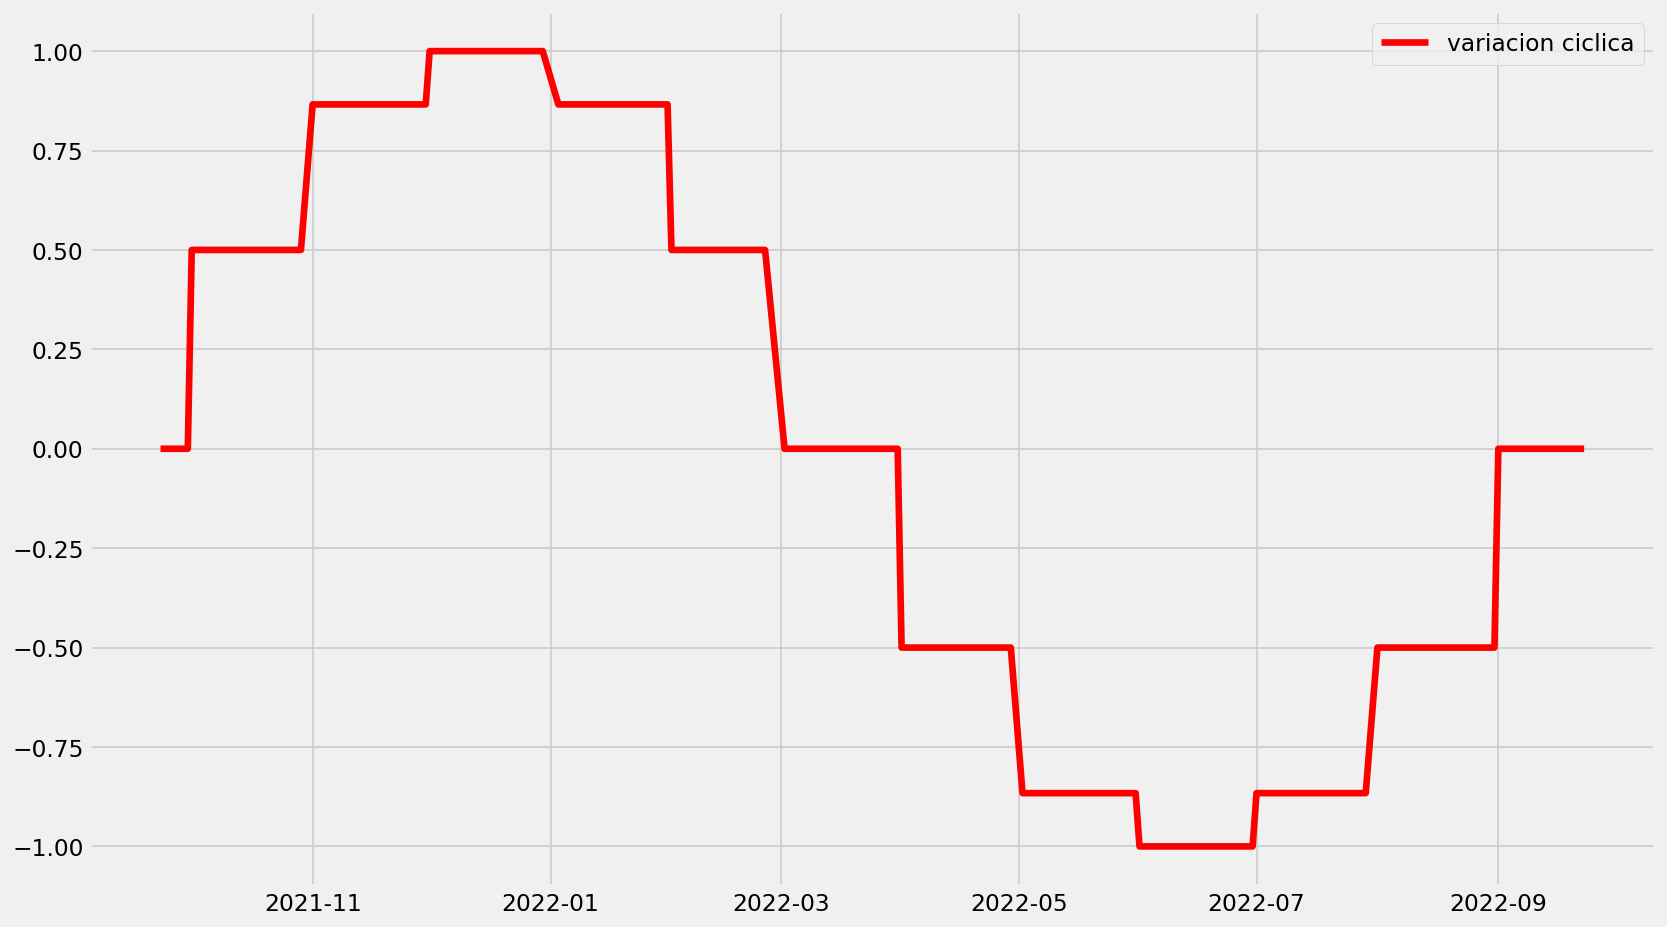

In [131]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.plot(data['month'], color = 'red', label = 'variacion ciclica')
plt.legend()

In [132]:
data.corr()

,ALUA,Aluminio,Merval,MetalM,Cobre,month
ALUA,1.000000,-0.510164,0.808449,0.459546,-0.662250,-0.248605
Aluminio,-0.510164,1.000000,-0.482787,0.115255,0.846257,0.244063
Merval,0.808449,-0.482787,1.000000,0.427005,-0.579637,-0.263894
MetalM,0.459546,0.115255,0.427005,1.000000,-0.213242,-0.700668
Cobre,-0.662250,0.846257,-0.579637,-0.213242,1.000000,0.428396
month,-0.248605,0.244063,-0.263894,-0.700668,0.428396,1.000000


Como era predecible agregar un componente ciclico no iba a tener mucho efecto ya que la serie original no presentaba estacionalidad. Pero aun asi decidi probar.

### Dividir train y test

In [312]:
train = data[0:233]
test = data[233:]

In [313]:
data

,ALUA,Aluminio,Merval,MetalM,Cobre,month
Date,,,,,,
2021-09-23,60.25,2949.5,74743.40,151.00,4.23,0.000011
2021-09-24,60.54,2915.5,74180.20,150.34,4.28,0.000011
2021-09-27,60.05,2883.5,75687.50,149.69,4.29,0.000011
2021-09-28,60.54,2944.5,75808.40,149.03,4.25,0.000011
2021-09-29,61.40,2911.5,76589.30,148.37,4.20,0.000011
...,...,...,...,...,...,...
2022-09-19,133.50,2251.0,150262.09,207.81,3.53,0.000011
2022-09-20,132.75,2245.5,147929.80,207.81,3.52,0.000011
2022-09-21,134.00,2202.5,146980.09,207.81,3.48,0.000011


## VAR

In [136]:
ad_fuller_result_1 = adfuller(data['ALUA'].diff()[1:])

print('Aluar')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(data['Merval'].diff()[1:])

print('merval')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(data['Aluminio'].diff()[1:])

print('aluminio')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(data['month'][1:])

print('Mes')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')


print('\n---------------------\n')

ad_fuller_result_4 = adfuller(data['MetalM'][1:])

print('Mes')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_4 = adfuller(data['Cobre'][1:])

print('Mes')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

Aluar
ADF Statistic: -7.2224685307492855
p-value: 2.093990129507862e-10

---------------------

merval
ADF Statistic: -7.040163805818067
p-value: 5.874837169885253e-10

---------------------

aluminio
ADF Statistic: -7.040163805818067
p-value: 5.874837169885253e-10

---------------------

Mes
ADF Statistic: -7.040163805818067
p-value: 5.874837169885253e-10

---------------------

Mes
ADF Statistic: -7.040163805818067
p-value: 5.874837169885253e-10

---------------------

Mes
ADF Statistic: -7.040163805818067
p-value: 5.874837169885253e-10


Todas nuestras series son estacionarias.

In [137]:
from statsmodels.tsa.stattools import grangercausalitytests

## granger causality tests

In [138]:
maxlag = 12

In [139]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [140]:
grangers_causation_matrix(data, variables = data.columns)

,ALUA_x,Aluminio_x,Merval_x,MetalM_x,Cobre_x,month_x
ALUA_y,1.0000,0.0894,0.0002,0.4248,0.0001,0.0720
Aluminio_y,0.1006,1.0000,0.1811,0.0001,0.1484,0.0103
Merval_y,0.0000,0.1146,1.0000,0.0840,0.0022,0.1470
MetalM_y,0.0391,0.0064,0.6683,1.0000,0.2320,0.0004
Cobre_y,0.0517,0.0000,0.1299,0.0549,1.0000,0.0001
month_y,0.0223,0.0041,0.0280,0.0041,0.0449,1.0000


**Si p-value es menor que el nivel de significancia, no rechazamos la hipotesis nula que x no causa y. teniendo un nivel de signifacncia de 0.05 el unico que no rechazamos la H0 es con merval. Nosotros buscamos un p value menor a 0.05 ya que eso quiere decir que x no causa y.**

Tanto aluminio, el indice del precio metal y mes no pasarian este test por lo que no las usaremos a la hora de hacer el modelo.

In [141]:
data.corr()

,ALUA,Aluminio,Merval,MetalM,Cobre,month
ALUA,1.000000,-0.510164,0.808449,0.459546,-0.662250,-0.248605
Aluminio,-0.510164,1.000000,-0.482787,0.115255,0.846257,0.244063
Merval,0.808449,-0.482787,1.000000,0.427005,-0.579637,-0.263894
MetalM,0.459546,0.115255,0.427005,1.000000,-0.213242,-0.700668
Cobre,-0.662250,0.846257,-0.579637,-0.213242,1.000000,0.428396
month,-0.248605,0.244063,-0.263894,-0.700668,0.428396,1.000000


## Test de cointegracion

In [142]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [143]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(data)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
ALUA   ::  72.81     > 83.9383   =>   False
Aluminio ::  46.41     > 60.0627   =>   False
Merval ::  25.46     > 40.1749   =>   False
MetalM ::  11.08     > 24.2761   =>   False
Cobre  ::  3.18      > 12.3212   =>   False
month  ::  0.09      > 4.1296    =>   False


**Relacion estadistica entre dos variables, y diferenciar para ver si la serie es estacionaria. Nos sirve para ver si cuando yo diferencio tienen una relacion significativa**

## Dividir en entrenamiento y test

In [155]:
data

,ALUA,Aluminio,Merval,MetalM,Cobre,month
Date,,,,,,
2021-09-23,60.25,2949.5,74743.40,151.00,4.23,0.000011
2021-09-24,60.54,2915.5,74180.20,150.34,4.28,0.000011
2021-09-27,60.05,2883.5,75687.50,149.69,4.29,0.000011
2021-09-28,60.54,2944.5,75808.40,149.03,4.25,0.000011
2021-09-29,61.40,2911.5,76589.30,148.37,4.20,0.000011
...,...,...,...,...,...,...
2022-09-19,133.50,2251.0,150262.09,207.81,3.53,0.000011
2022-09-20,132.75,2245.5,147929.80,207.81,3.52,0.000011
2022-09-21,134.00,2202.5,146980.09,207.81,3.48,0.000011


In [354]:
data3 = data.copy()
data3 = data3.drop(['Aluminio','MetalM','month'],axis = 1)

In [337]:
train = data3[0:233]
test = data3[233:]

In [338]:
train

,ALUA,Aluminio,Merval,MetalM,Cobre,month
Date,,,,,,
2021-09-23,60.25,2949.50,74743.40,151.00,4.23,0.000011
2021-09-24,60.54,2915.50,74180.20,150.34,4.28,0.000011
2021-09-27,60.05,2883.50,75687.50,149.69,4.29,0.000011
2021-09-28,60.54,2944.50,75808.40,149.03,4.25,0.000011
2021-09-29,61.40,2911.50,76589.30,148.37,4.20,0.000011
...,...,...,...,...,...,...
2022-08-31,145.00,2283.38,136241.00,207.81,3.52,-0.499992
2022-09-01,147.25,2295.00,136302.09,207.81,3.41,0.000011
2022-09-05,144.50,2285.50,138268.00,207.81,3.45,0.000011


## Ver si la serie es estacionaria

In [339]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [340]:
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ALUA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1187
 No. Lags Chosen       = 3
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.7076. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Aluminio" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9126
 No. Lags Chosen       = 4
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.7838. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Merval" 
    -----------------------------------------------
 Null Hypothesis: Data has u

In [341]:
train_diff = train.diff().dropna()

In [168]:
for name, column in train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ALUA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8972
 No. Lags Chosen       = 2
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Merval" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.1222
 No. Lags Chosen       = 4
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cobre" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

como todas nuestras variables son estacionarias las dejamos ahi.

## Selecionar orden p

In [169]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

In [342]:
model = VAR(train_diff)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  16.318249425217825
BIC :  16.944143554403606
FPE :  12217266.456822572
HQIC:  16.57069429584269 

Lag Order = 2
AIC :  16.2077440122179
BIC :  17.373701343070117
FPE :  10945814.256353933
HQIC:  16.678067686690355 

Lag Order = 3
AIC :  16.300541611244434
BIC :  18.00990540340681
FPE :  12029057.224258915
HQIC:  16.990141401742424 

Lag Order = 4
AIC :  16.523982904336865
BIC :  18.780131344438473
FPE :  15086252.98485723
HQIC:  17.434270557445323 

Lag Order = 5
AIC :  16.616940628244592
BIC :  19.423287338603803
FPE :  16638729.90412984
HQIC:  17.749342527796017 

Lag Order = 6
AIC :  16.59622428368329
BIC :  19.956218840490582
FPE :  16420885.95665852
HQIC:  17.952181657162335 

Lag Order = 7
AIC :  16.63828391555435
BIC :  20.55541237674875
FPE :  17310647.677416082
HQIC:  18.219253044140356 

Lag Order = 8
AIC :  16.83983988036058
BIC :  21.31762532342032
FPE :  21486917.25091591
HQIC:  18.647292312683962 

Lag Order = 9
AIC :  17.05368346256828
BIC :  22.0956

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [343]:
model = VAR(train.diff()[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [344]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        19.05       19.14   1.868e+08       19.08
1        16.44      17.11*   1.384e+07      16.71*
2       16.28*       17.51  1.176e+07*       16.78
3        16.35       18.16   1.270e+07       17.08
4        16.57       18.94   1.575e+07       17.53
5        16.67       19.62   1.764e+07       17.86
6        16.83       20.34   2.072e+07       18.25
7        16.85       20.93   2.151e+07       18.50
8        17.03       21.69   2.620e+07       18.91
9        17.21       22.43   3.192e+07       19.32
10       17.34       23.14   3.769e+07       19.69
11       17.42       23.79   4.217e+07       20.00
12       17.51       24.44   4.781e+07       20.31
13       17.67       25.17   5.907e+07       20.70
14       17.82       25.90   7.327e+07       21.09
15       17.92       26.56   8.634e+07       21.41
16       17.87       27.09   8.

## Modelo VAR

In [345]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Oct, 2022
Time:                     20:03:11
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    17.3737
Nobs:                     230.000    HQIC:                   16.6781
Log likelihood:          -3744.03    FPE:                1.09458e+07
AIC:                      16.2077    Det(Omega_mle):     7.87005e+06
--------------------------------------------------------------------
Results for equation ALUA
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.269790         0.177562            1.519           0.129
L1.ALUA             0.102147         0.072583            1.407           0.159
L1.Aluminio        -0.001347         0.003000           -0.449       

## Test durbin watson

In [346]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)
out

array([2.01979343, 2.00081061, 2.11127915, 1.99163932, 2.07941514,
       1.98379993])

correlacion entre los residuos y si hay algun patron en la serie de tiempo que todavia no fue explicado, de ser asi incrementar el orden del modelo.
Mientras mas cerca de dos sea, menor es la correlacion. si es 0 hay correlacion positiva y a 4 correlacion negativa.

## Forecast

In [347]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train_diff.values[-lag_order:]
forecast_input

2


array([[ 2.5000e-01, -2.5000e+01, -9.5870e+02,  0.0000e+00,  1.0000e-02,
         0.0000e+00],
       [-4.7500e+00, -2.5500e+01,  3.6922e+03,  0.0000e+00, -3.0000e-02,
         0.0000e+00]])

In [319]:
nobs = 12

In [348]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
data_forecast = pd.DataFrame(fc, index=data3.index[-nobs:], columns=data3.columns + '_2d')
data_forecast

,ALUA_2d,Aluminio_2d,Merval_2d,MetalM_2d,Cobre_2d,month_2d
Date,,,,,,
2022-09-08,-0.368580,9.690296,-3515.727911,-0.006445,-0.024298,0.024049
2022-09-09,-0.278587,10.370605,1843.777819,0.086890,0.000824,-0.015171
2022-09-12,0.275961,0.327413,382.765767,0.094972,0.008110,-0.003227
2022-09-13,0.326430,-2.978896,-9.314895,0.101478,0.005598,-0.003577
2022-09-14,0.346106,-3.929238,525.637583,0.104610,-0.002793,-0.000270
2022-09-15,0.315901,-3.720629,255.280359,0.111163,-0.004369,0.000482
2022-09-16,0.328010,-3.642510,201.568899,0.119765,-0.004480,0.000270
2022-09-19,0.328496,-3.589375,308.621621,0.128628,-0.004071,0.000124
2022-09-20,0.328887,-3.543845,254.500049,0.136872,-0.003997,0.000144


In [349]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    data_fc = data_forecast.copy()
    columns = train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            data_fc[str(col)+'_1d'] = (train[col].iloc[-1]-train[col].iloc[-2]) + data_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        data_fc[str(col)+'_forecast'] = train[col].iloc[-1] + data_fc[str(col)+'_1d'].cumsum()
    return data_fc

In [352]:
df_results = invert_transformation(train, data_forecast, second_diff=True)        
df_results.loc[:, ['ALUA_forecast', 'Merval_forecast', 'Cobre_forecast']]
                   

,ALUA_forecast,Aluminio_forecast,Merval_forecast,MetalM_forecast,Cobre_forecast,month_forecast
Date,,,,,,
2022-09-08,134.881420,2219.190296,141177.972089,207.803555,3.375702,0.024060
2022-09-09,129.484252,2213.751197,143198.221997,207.884000,3.322228,0.032938
2022-09-12,124.363047,2208.639511,145601.237672,208.059418,3.276864,0.038589
2022-09-13,119.568271,2200.548929,147994.938452,208.336313,3.237098,0.040663
2022-09-14,115.119602,2188.529110,150914.276815,208.717818,3.194538,0.042467
2022-09-15,110.986833,2172.788662,154088.895536,209.210486,3.147610,0.044753
2022-09-16,107.182075,2153.405703,157465.083156,209.822919,3.096202,0.047309
2022-09-19,103.705813,2130.433370,161149.892397,210.563981,3.040723,0.049989
2022-09-20,100.558438,2103.917192,165089.201688,211.441914,2.981247,0.052813


In [206]:
test

,ALUA,Merval,Cobre
Date,,,
2022-09-08,138.00,141509.30,3.53
2022-09-09,140.00,144642.20,3.57
2022-09-12,141.00,144714.09,3.62
2022-09-13,139.75,142941.59,3.57
2022-09-14,136.50,146750.00,3.53
2022-09-15,134.25,144765.59,3.50
2022-09-16,133.75,145741.80,3.53
2022-09-19,133.50,150262.09,3.53
2022-09-20,132.75,147929.80,3.52


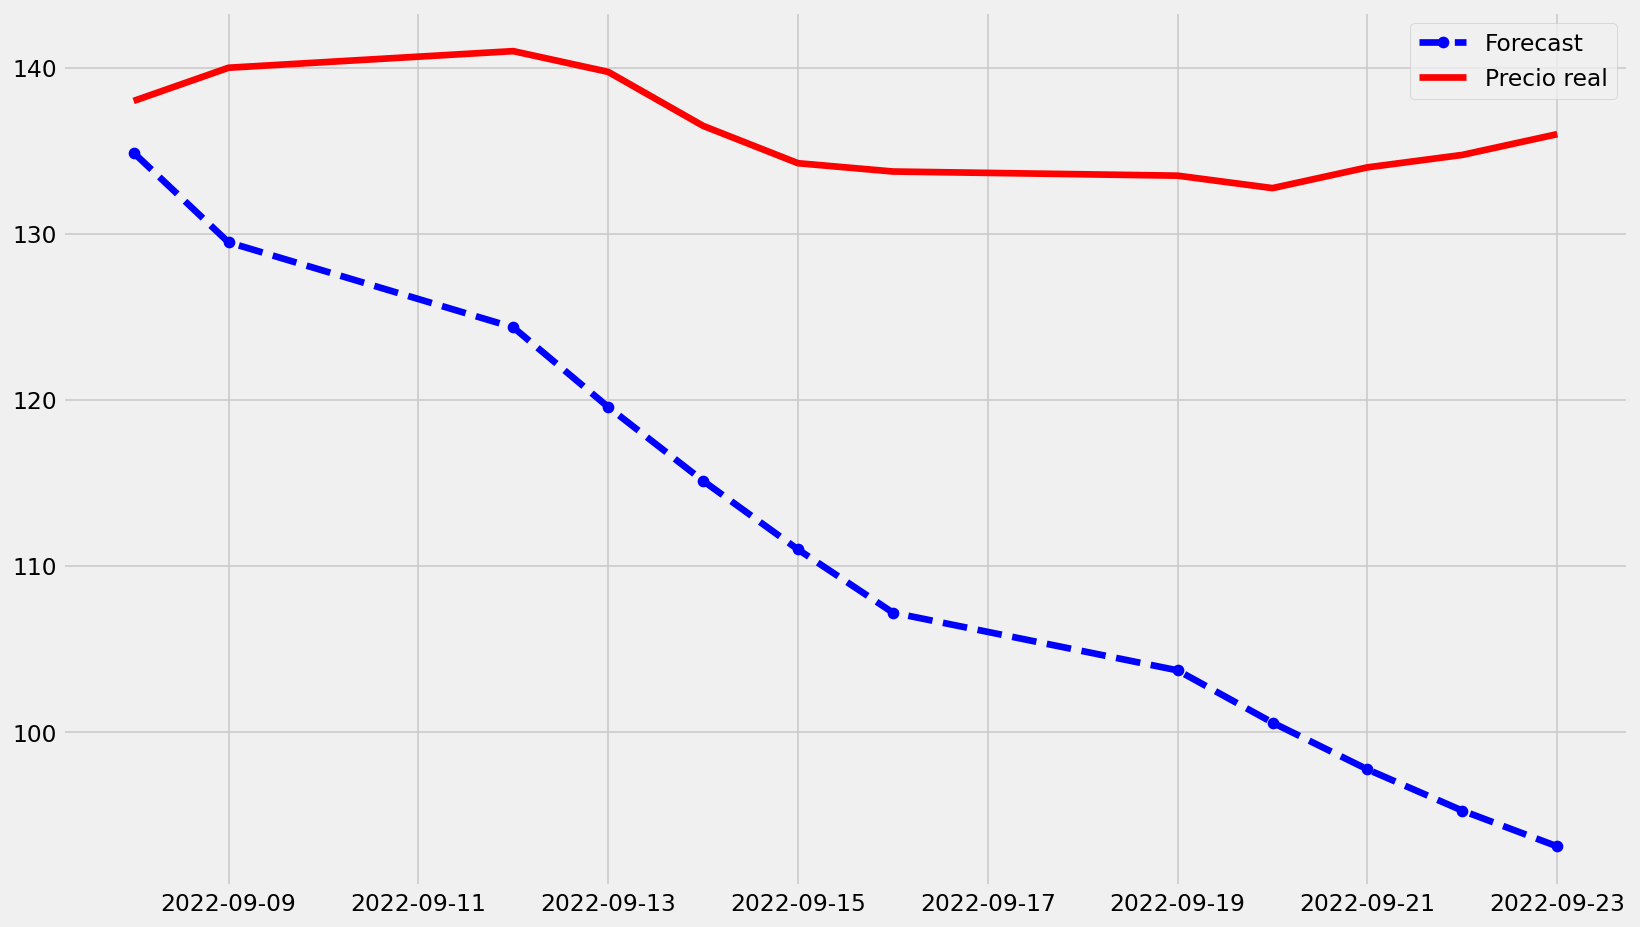

In [353]:
plt.figure(figsize=(15,9))
plt.grid(True)
date_range = test.index
plt.plot(date_range, df_results['ALUA_forecast'], color = 'blue',marker = 'o',linestyle = 'dashed', label = 'Forecast')
plt.plot(date_range, (test['ALUA']), color = 'red', label = 'Precio real')
plt.legend()

Como podemos ver con un modelo Var(2),var(1) y var(4), no tuvimos los mejores resultados, por lo que vamos a probar modificar las variables.

## Probar agrendo LOG

In [335]:
data4 = data3.copy()

In [233]:
skew_df = pd.DataFrame(data4.select_dtypes(np.number).columns, columns=['Feature'])
skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(data4[feature]))
skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
skew_df

,Feature,Skew,Absolute Skew,Skewed
0,ALUA,0.873893,0.873893,True
1,Merval,0.724196,0.724196,True
2,Cobre,-0.725845,0.725845,True


In [234]:
for column in skew_df.query("Skewed == True")['Feature'].values:
    data4[column] = np.log(data4[column])

In [235]:
data4

,ALUA,Merval,Cobre
Date,,,
2021-09-23,4.098503,11.221816,1.442202
2021-09-24,4.103304,11.214253,1.453953
2021-09-27,4.095178,11.234368,1.456287
2021-09-28,4.103304,11.235964,1.446919
2021-09-29,4.117410,11.246213,1.435085
...,...,...,...
2022-09-19,4.894101,11.920136,1.261298
2022-09-20,4.888468,11.904493,1.258461
2022-09-21,4.897840,11.898052,1.247032


In [236]:
train_log = np.log(train)
test_log = np.log(test)
train_log

,ALUA,Merval,Cobre
Date,,,
2021-09-23,4.098503,11.221816,1.442202
2021-09-24,4.103304,11.214253,1.453953
2021-09-27,4.095178,11.234368,1.456287
2021-09-28,4.103304,11.235964,1.446919
2021-09-29,4.117410,11.246213,1.435085
...,...,...,...
2022-08-31,4.976734,11.822181,1.258461
2022-09-01,4.992132,11.822629,1.226712
2022-09-05,4.973280,11.836949,1.238374


In [237]:
for name, column in train_log.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ALUA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4713
 No. Lags Chosen       = 2
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.5476. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Merval" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.853
 No. Lags Chosen       = 5
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0511. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Cobre" 
    -----------------------------------------------
 Null Hypothesis: Data has unit 

In [238]:
train_diff_log = train_log.diff().dropna()

In [239]:
for name, column in train_diff_log.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "ALUA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0225
 No. Lags Chosen       = 1
 Critical value 1%     = -3.459
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Merval" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.4606
 No. Lags Chosen       = 6
 Critical value 1%     = -3.46
 Critical value 5%     = -2.874
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cobre" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

In [240]:
model_log = VAR(train_diff_log)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model_log.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -18.334343770278448
BIC :  -18.15551687622537
FPE :  1.0901849489313823e-08
HQIC:  -18.26221666438563 

Lag Order = 2
AIC :  -18.433092771317884
BIC :  -18.11918118224229
FPE :  9.877204032041065e-09
HQIC:  -18.306467166652226 

Lag Order = 3
AIC :  -18.439437219098995
BIC :  -17.98960464221416
FPE :  9.815819810906334e-09
HQIC:  -18.257963590020577 

Lag Order = 4
AIC :  -18.410377841237345
BIC :  -17.823779246810926
FPE :  1.0107315298317758e-08
HQIC:  -18.173703051429147 

Lag Order = 5
AIC :  -18.446884327845293
BIC :  -17.72266582194614
FPE :  9.74821264465341e-09
HQIC:  -18.154651579573958 

Lag Order = 6
AIC :  -18.395948255802328
BIC :  -17.533246950676133
FPE :  1.026264962261985e-08
HQIC:  -18.047797038287438 

Lag Order = 7
AIC :  -18.408949024765448
BIC :  -17.406892906785483
FPE :  1.013705192055555e-08
HQIC:  -18.004515061638795 

Lag Order = 8
AIC :  -18.338912586094832
BIC :  -17.196620381232655
FPE :  1.088248492214402e-08
HQIC:  -17.87782778193070

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [256]:
model_log = VAR(train_log.diff()[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [257]:
sorted_order=model_log.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.98      -17.93   1.553e-08      -17.96
1       -18.24     -18.05*   1.197e-08      -18.16
2       -18.35      -18.02   1.071e-08     -18.22*
3       -18.37      -17.89   1.054e-08      -18.18
4       -18.34      -17.73   1.080e-08      -18.09
5      -18.40*      -17.64  1.027e-08*      -18.09
6       -18.36      -17.46   1.067e-08      -17.99
7       -18.38      -17.34   1.041e-08      -17.96
8       -18.33      -17.14   1.099e-08      -17.85
9       -18.29      -16.96   1.149e-08      -17.75
10      -18.25      -16.78   1.194e-08      -17.65
11      -18.23      -16.62   1.215e-08      -17.58
12      -18.24      -16.48   1.211e-08      -17.53
13      -18.20      -16.30   1.266e-08      -17.43
14      -18.15      -16.11   1.334e-08      -17.32
15      -18.13      -15.95   1.362e-08      -17.25
16      -18.10      -15.77   1.

In [275]:
model_fitted_log = model_log.fit(2)
model_fitted_log.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 22, Oct, 2022
Time:                     19:47:32
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -18.1192
Nobs:                     230.000    HQIC:                  -18.3065
Log likelihood:           1161.74    FPE:                9.87720e-09
AIC:                     -18.4331    Det(Omega_mle):     9.02760e-09
--------------------------------------------------------------------
Results for equation ALUA
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002941         0.001774            1.658           0.097
L1.ALUA           0.124452         0.069731            1.785           0.074
L1.Merval        -0.005812         0.007381           -0.787           0.431


In [368]:
# Get the lag order
lag_order = model_fitted_log.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train_diff_log.values[-lag_order:]
forecast_input

2


array([[ 0.00172861, -0.00695779,  0.00289436],
       [-0.03336569,  0.02653448, -0.00870833]])

In [369]:
fc1 = model_fitted_log.forecast(y=forecast_input, steps=nobs)
data_forecast1 = pd.DataFrame(fc1, index=data4.index[-nobs:], columns=data4.columns + '_2d')
data_forecast1

,ALUA_2d,Merval_2d,Cobre_2d
Date,,,
2022-09-08,-0.001593,-0.015749,-0.001673
2022-09-09,-0.000026,0.016627,0.002881
2022-09-12,0.002811,-0.001435,0.000097
2022-09-13,0.003323,0.009497,-0.000666
2022-09-14,0.003507,0.001719,-0.000835
2022-09-15,0.003622,0.001736,-0.000972
2022-09-16,0.003637,0.003850,-0.000940
2022-09-19,0.003637,0.002151,-0.000946
2022-09-20,0.003651,0.002631,-0.000966


In [382]:
def invert_transformation1(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    data_fc1 = data_forecast1.copy()
    columns = train_log.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            data_fc1[str(col)+'_1d'] = (train_log[col].iloc[-1]-train_log[col].iloc[-2]) + data_fc1[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        data_fc1[str(col)+'_forecast'] = train_log[col].iloc[-1] + data_fc1[str(col)+'_1d'].cumsum()
    return data_fc1

In [383]:
df_results1 = invert_transformation1(train_log, data_forecast1, second_diff=True)        
df_results1.loc[:, ['ALUA_forecast', 'Merval_forecast', 'Cobre_forecast']]

,ALUA_forecast,Merval_forecast,Cobre_forecast
Date,,,
2022-09-08,4.906684,11.867312,1.222179
2022-09-09,4.871700,11.894725,1.214679
2022-09-12,4.839526,11.920703,1.207276
2022-09-13,4.810675,11.956177,1.199207
2022-09-14,4.785330,11.993370,1.190303
2022-09-15,4.763607,12.032300,1.180428
2022-09-16,4.745521,12.075079,1.169612
2022-09-19,4.731073,12.120010,1.157850
2022-09-20,4.720274,12.167571,1.145122


In [372]:
df_results1['Alua_predict'] = np.exp(df_results1['ALUA_forecast'])

In [373]:
df_results1

,ALUA_2d,Merval_2d,Cobre_2d,ALUA_1d,ALUA_forecast,Merval_1d,Merval_forecast,Cobre_1d,Cobre_forecast,Alua_predict
Date,,,,,,,,,,
2022-09-08,-0.001593,-0.015749,-0.001673,-0.034958,4.906684,0.010786,11.867312,-0.010381,1.222179,135.190403
2022-09-09,-0.000026,0.016627,0.002881,-0.034985,4.871700,0.027413,11.894725,-0.007500,1.214679,130.542605
2022-09-12,0.002811,-0.001435,0.000097,-0.032174,4.839526,0.025978,11.920703,-0.007403,1.207276,126.409380
2022-09-13,0.003323,0.009497,-0.000666,-0.028851,4.810675,0.035474,11.956177,-0.008069,1.199207,122.814437
2022-09-14,0.003507,0.001719,-0.000835,-0.025344,4.785330,0.037193,11.993370,-0.008904,1.190303,119.740888
2022-09-15,0.003622,0.001736,-0.000972,-0.021723,4.763607,0.038929,12.032300,-0.009876,1.180428,117.167818
2022-09-16,0.003637,0.003850,-0.000940,-0.018086,4.745521,0.042779,12.075079,-0.010816,1.169612,115.067767
2022-09-19,0.003637,0.002151,-0.000946,-0.014449,4.731073,0.044930,12.120010,-0.011762,1.157850,113.417141
2022-09-20,0.003651,0.002631,-0.000966,-0.010798,4.720274,0.047561,12.167571,-0.012728,1.145122,112.199041


In [289]:
test

,ALUA,Merval,Cobre
Date,,,
2022-09-08,138.00,141509.30,3.53
2022-09-09,140.00,144642.20,3.57
2022-09-12,141.00,144714.09,3.62
2022-09-13,139.75,142941.59,3.57
2022-09-14,136.50,146750.00,3.53
2022-09-15,134.25,144765.59,3.50
2022-09-16,133.75,145741.80,3.53
2022-09-19,133.50,150262.09,3.53
2022-09-20,132.75,147929.80,3.52


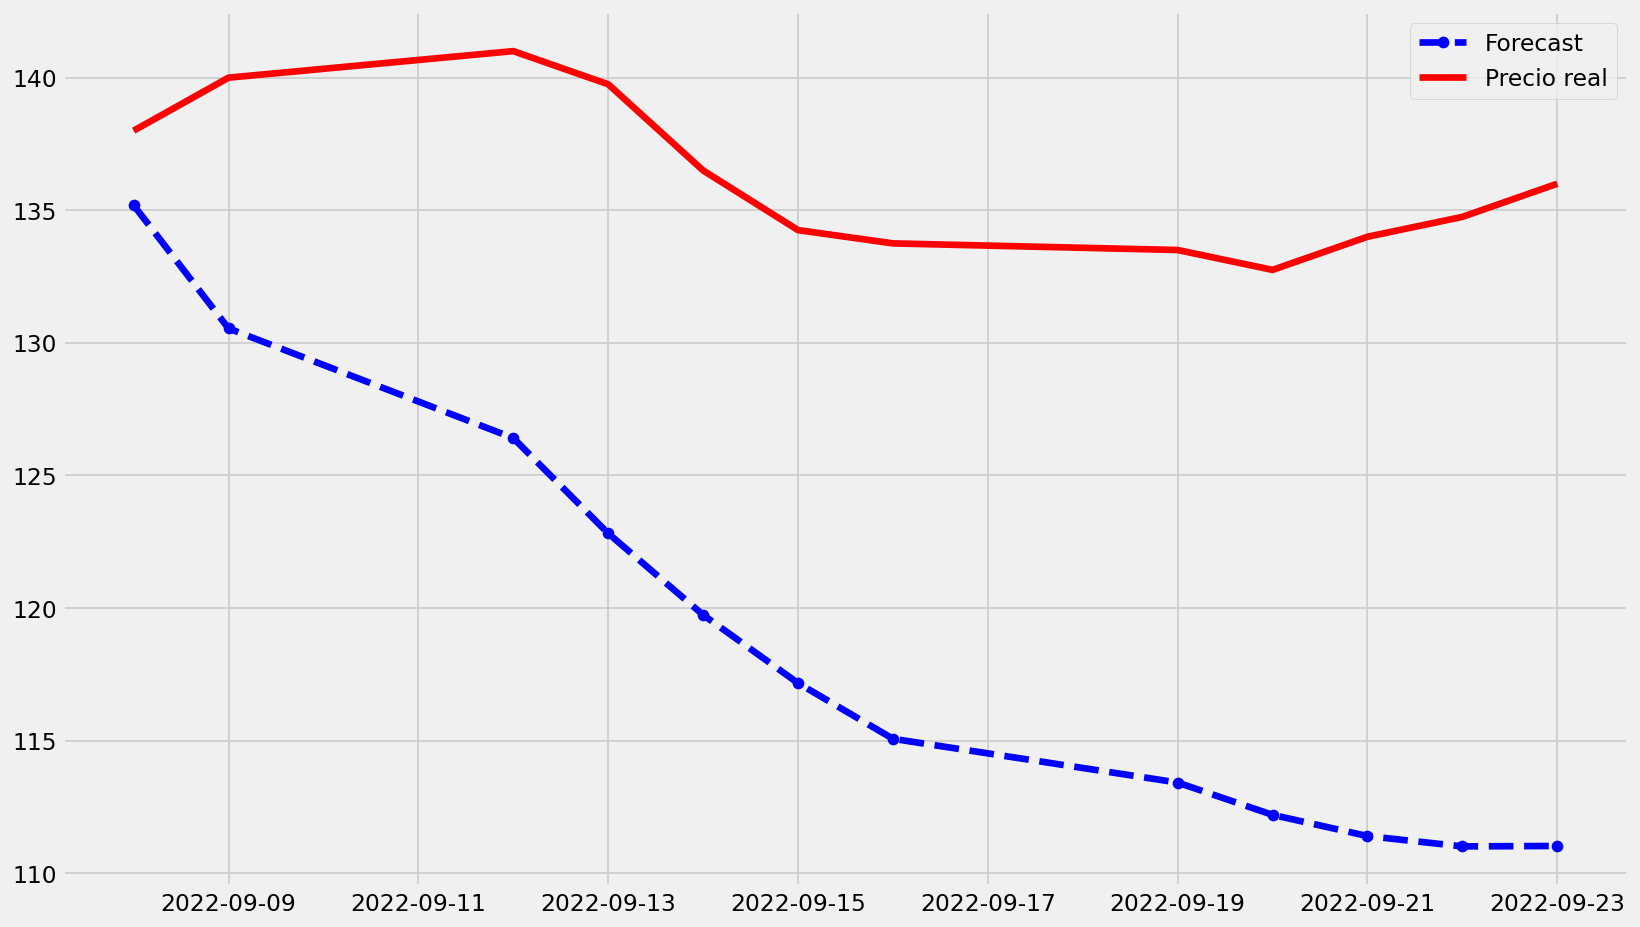

In [374]:
plt.figure(figsize=(15,9))
plt.grid(True)
date_range = test.index
plt.plot(date_range, df_results1['Alua_predict'], color = 'blue',marker = 'o',linestyle = 'dashed', label = 'Forecast')
plt.plot(date_range, (test['ALUA']), color = 'red', label = 'Precio real')
plt.legend()